# Estimating the reliability of relations extracted by multiple biomedical reading systems with minimal training data

## Summary

Interim summary of findings:

1. At the relation level, classifiers generate probabilities that are very close to the exact underlying joint probability distribution.

1. In the small data case, and especially the very small data case, Belief wins.

2. When there are only two readers, Belief does well (along with log-Logistic Regression), presumably because it explicitly captures information about correctness that is implied by the high counts. Binary random forests do poorly here.

3. On the other hand, binary random forests are the best in the baseline case of a full curation dataset where there are many readers (and presumably substantial but not total overlap). Belief is good (on par with Random Forests) but not the best.

4. Using more readers increases AUROC for all classifiers, which is a good justification of our multi-reader strategy.




## Introduction

Text mining is an increasingly effective tool for extracting structured information from the scientific literature for use in search, data analysis, and modeling (REFs). In the biomedical sciences, both commercial and non-commercial tools have been developed to extract many types of information, including protein-protein interactions (REFs), gene-disease relationships (REFs), and information on gene regulation and function (REFs). With growing interest in rapidly compiling systematic knowledge networks to accelerate discovery, especially in the context of emerging health crises such as COVID-19, interest in and applications of these natural language processing (NLP)  systems is likely to increase (REFs).

As the number and diversity of biomedical NLP systems has increased, it has become increasingly desirable to combine the results from more than one system to boost both the precision and recall of the information extracted. One of the key technical challenges in combining information is the need to estimate the reliability of extractions derived from multiple systems. Combining predictions from multiple classifiers is a well-established way of boosting performance in machine learning applications (REFs). Typically this is achieved by tuning the relative contributions of each classifier using a gold-standard dataset. However, in domains where training data is scarce, as is the case for many biomedical NLP tasks, systems may be based on deterministic rules or heuristics rather than supervised learning, making estimates of reliability difficult even for a single reading system. Even when combining systems based on supervised learning, the data used for the original training and validation may be sufficiently different from the target domain as to make assessments of recall and precision unreliable. This can occur when processing full-text articles after training only on abstracts, or transitioning to a very broad set of documents (e.g. all of PubMed) after training on only highly relevant documents.

In this paper we describe a straightforward approach to estimating joint extraction precision that only requires estimates of the precision of each component reader by assuming that reader errors are independent. These precision values can be based on limited manual curation or even *a priori* estimates. To demonstrate the approach, we obtained a corpus of relations by processing 570,000 scientific abstracts and full-texts with five different reading systems, and manually curated ~1,000 relations supported by ~5,000 underlying sentences for correctness. Using this dataset, we show that even though reader errors are *in fact* correlated, assuming error independence yields relation "belief scores" that, though not representing calibrated probabilities, nevertheless serve as a metric that can be used to adjust the false discovery rate in downstream applications. The receiver-operator characteristics of this approach are comparable to logistic regression and other classification methods, while requiring far less data. In real-world applications where reader overlap is minimal, belief scores are nearly as effective as exact knowledge of the joint probability distribution in separating correct from incorrect extractions.

## Results

### Article corpus, extracted relations, and curated dataset

For this study we defined a corpus of ~580,000 scientific articles enriched for information on protein interactions by searching the Entrez gene database for articles manually curated as relevant to one or more human genes (REF Entrez?). For these articles we obtained <span class="mark">XXX</span> abstracts and <span class="mark">YYY</span> full texts; abstracts were obtained from MEDLINE, full texts were obtained from either 1) the PubMed Central open access subset, 2) the PubMed author's manuscript collection, or 3) the Elsevier text and data mining API.

From these articles we combined extractions from five reading systems: REACH (REF), Sparser (REF), Medscan (REF), RLIMS-P (REF), and TRIPS (REF) and used the INDRA assembly system to normalize the resulting extractions into a consistent format (INDRA Ref). 81% of the assembled relations were obtained from only a single reading system, with the remaining 19% from two or more (<span class="mark">Tables 1 and 2 and Figure 1</span>).

In [1]:
# Imports.
import pickle
import random
import itertools
from collections import Counter
from tqdm import tqdm
import numpy as np
import pandas as pd
from venn import venn
from numpy import interp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, ComplementNB
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve
from indra.tools import assemble_corpus as ac
from multiprocessing import Pool
from bioexp.curation.belief_models import *
from bioexp.curation.model_fit import ModelFit, ens_sample

%matplotlib notebook

In [2]:
# Load pickle of assembled statements.
all_stmts = ac.load_statements('../data/bioexp_asmb_preassembled.pkl')

INFO: [2020-11-02 11:44:39] indra.tools.assemble_corpus - Loading ../data/bioexp_asmb_preassembled.pkl...
INFO: [2020-11-02 11:46:18] indra.tools.assemble_corpus - Loaded 895580 statements


In [3]:
# Filter out statements with None agents and those with only DB support.
# The list of readers: 
reader_list = ['reach', 'sparser', 'medscan', 'rlimsp', 'trips']
reader_abbrevs = {'reach': 'R', 'sparser': 'S', 'medscan': 'M',
                  'rlimsp': 'P', 'trips': 'T'}
reader_stmts = []
for stmt in tqdm(all_stmts):
    if None in stmt.agent_list():
        continue
    if not set([ev.source_api for ev in stmt.evidence]).intersection(set(reader_list)):
        continue
    reader_stmts.append(stmt)
    

100%|██████████| 895580/895580 [00:04<00:00, 187354.66it/s]


In [175]:
# Load and preprocess the curation dataset.

curation_data_file = 'curation_dataset.pkl'
curation_data_with_supp_file = 'curation_dataset_with_supp.pkl'

def load_curation_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
        df = pd.DataFrame.from_records(dataset)
        df = df.fillna(0)
    # Every column except agent names and stmt type should be int
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('agA_name', 'agA_ns', 'agA_id', 'stmt_type',
                                 'agB_name', 'agB_ns', 'agB_id')}
    df = df.astype(dtype_dict)
    return df

def binarize_count_data(df):
    # First convert to true/false
    dtype_dict = {col: 'bool' for col in df.columns
                  if col not in ('stmt_num', 'stmt_hash', 'agA_name',
                                 'agA_ns', 'agA_id', 'stmt_type', 'agB_name',
                                 'agB_ns', 'agB_id')}
    bin_df = df.astype(dtype_dict)
    # Then convert true/false into 1/0
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('stmt_num', 'stmt_hash', 'agA_name',
                                 'agA_ns', 'agA_id', 'stmt_type', 'agB_name',
                                 'agB_ns', 'agB_id')}
    bin_df = bin_df.astype(dtype_dict)
    return bin_df

kge_df = load_curation_data(curation_data_file)
supp_df = load_curation_data(curation_data_with_supp_file)
bin_df = binarize_count_data(kge_df)

In [68]:
# Table 1: Distribution of reader frequencies in corpus and curation data.
# (excluding database only statements)

def reader_set_to_tuple(rset, r_list, r_abbrevs):
    """Converts a frozen set of sources e.g. {reach, sparser} into a tuple 
       of the form (R, S, _, _, _) for use in displaying results."""
    rtup = []
    # Follow the order of readers in reader_list
    for r in r_list:
        if r in rset:
            rtup.append(r_abbrevs[r])
        else:
            rtup.append('_')
    return tuple(rtup)

def get_reader_freq_from_stmts(stmts, source_list, source_abbrevs):
    """Return dictionary showing frequency of reader combinations."""
    all_ev_cts = []
    # Get unique reader evidence sources for each statement
    for stmt in tqdm(stmts):
        sources = frozenset([ev.source_api for ev in stmt.evidence
                       if ev.source_api in source_list])
        if sources:
            all_ev_cts.append(sources)
    # Build up a dictionary mapping the reader combinations (as frozensets) to their
    # frequency in the set of statements
    all_ev_ctr = Counter(all_ev_cts)
    #all_ev_ctr_list = sorted([(k, (v / len(all_ev_cts)))
    #                          for k, v in all_ev_ctr.items()], key=lambda x: x[1], reverse=True)
    all_ev_ctr_dict = {reader_set_to_tuple(k, source_list, source_abbrevs):
                       (v / len(all_ev_cts)) for k, v in all_ev_ctr.items()}
    return all_ev_ctr_dict

def get_reader_counts_from_stmts(stmts):
    data = []
    for stmt in tqdm(stmts):
        ev_dict = dict(Counter([ev.source_api for ev in stmt.evidence]))
        ev_dict['stmt_hash'] = stmt.get_hash()
        ev_dict['stmt_type'] = stmt.__class__.__name__
        ev_dict['agA_name'] = stmt.agent_list()[0].name
        if len(stmt.agent_list()) == 2:
            ev_dict['agB_name'] = stmt.agent_list()[1].name
        else:
            continue
        data.append(ev_dict)
    df = pd.DataFrame(data).fillna(0)
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('stmt_num', 'stmt_hash', 'agA_name', 'stmt_type', 'agB_name')}
    return df.astype(dtype_dict)

def get_reader_freq_from_curation(df, col_list, r_abbrevs=None):
    """Build up dictionary of the proportions of each evidence combination in the
       curation dataset. Also return a mapping between the unique evidence combo
       and a dataframe with the curated statements for that combination."""
    if r_abbrevs is None:
        r_abbrevs = {c: c for c in col_list}
    df_ev_dict = {}
    total_rows = df.shape[0]
    df_subgroup_dict = {}
    for gb_key, gb_df in df.groupby(by=col_list):
        freq = (gb_df.shape[0] / total_rows) # Proportion of rows from this group
        label_set = frozenset([col for ix, col in enumerate(col_list)
                               if gb_key[ix] == 1])
        label_tup = reader_set_to_tuple(label_set, col_list, r_abbrevs)
        df_ev_dict[label_tup] = freq
        df_subgroup_dict[label_tup] = gb_df
    return (df_ev_dict, df_subgroup_dict)

def make_df(d, index_name, colname):
    """Build dataframe from a dictionary with dict keys as the index."""
    index, raw_cols = zip(*d.items())
    cols = tuple([c for c in raw_cols])
    index_obj = pd.Index(index, name=index_name, tupleize_cols=False)
    return pd.DataFrame(cols, columns=[colname], index=index_obj)

reader_counts = get_reader_counts_from_stmts(reader_stmts)
reader_freqs = get_reader_freq_from_stmts(reader_stmts, reader_list, reader_abbrevs)
curation_freqs, curation_dfs = get_reader_freq_from_curation(bin_df, reader_list, reader_abbrevs)
stmt_freq_df = make_df(reader_freqs, 'Readers', 'Corpus Freq.')
cur_freq_df = make_df(curation_freqs, 'Readers', 'Curation Freq.')
stmt_freq_df.join(cur_freq_df).sort_values('Corpus Freq.', ascending=False).fillna(0)

100%|██████████| 705022/705022 [00:01<00:00, 429241.08it/s]


,Corpus Freq.,Curation Freq.
Readers,,
"(R, _, _, _, _)",0.449950,0.156048
"(_, _, M, _, _)",0.201791,0.079409
"(_, S, _, _, _)",0.153938,0.029548
"(R, _, M, _, _)",0.078537,0.087719
"(R, S, _, _, _)",0.049878,0.060018
"(R, S, M, _, _)",0.028466,0.061865
"(_, S, M, _, _)",0.010037,0.011080
"(R, S, M, _, T)",0.005133,0.141274
"(_, _, _, _, T)",0.004401,0.056325


In [70]:
kge_df.shape

(1083, 21)

<AxesSubplot:>

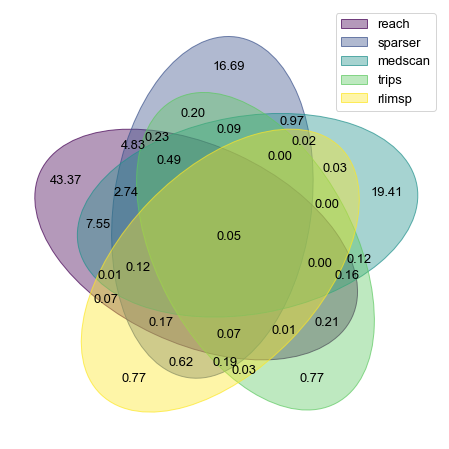

In [71]:
# Figure 1: Venn diagram of reader frequencies in corpus.
def source_venn(stmts, source_list):
    reader_uuids = {}
    for stmt in stmts:
        stmt_sources = frozenset([ev.source_api for ev in stmt.evidence
                             if ev.source_api in source_list])
        # Skip statements with no sources in the given list
        if not stmt_sources:
            continue
        for source in stmt_sources:
            if source not in reader_uuids:
                reader_uuids[source] = set()
            reader_uuids[source].add(stmt.uuid)
    return reader_uuids

venn(source_venn(all_stmts, reader_list), fmt='{percentage:.2f}')

In [72]:
# Table 2: Frequencies of relations in corpus by total number of sources.
def marginal_reader_freqs(freqs):
    rcount_dict = {}
    for rtup, freq in freqs.items():
        # Count the number of readers in the freq key tuple
        # Make a set, then turn into a string, then replace'_' with nothing
        rstr = ''.join(set(rtup)).replace('_', '')
        rcount = len(rstr)
        if rcount not in rcount_dict:
            rcount_dict[rcount] = 0
        rcount_dict[rcount] += freq
    return rcount_dict

rcount_dict = marginal_reader_freqs(reader_freqs)
make_df(rcount_dict, 'Num. readers', 'Freq.')

,Freq.
Num. readers,
1,0.813014
2,0.144215
3,0.035539
4,0.006722
5,0.000509


To evaluate different approaches to estimating the reliability we curated a corpus of relations drawn from each reader. For each of the five reading systems we sampled relations supported by between one and ten evidence sentences processed by that reader. For each relation, we manually reviewed each evidence sentence to determine whether it supported the relation extracted by the reader. A relation was determined to be "correct" if it was supported by at least one evidence sentence from any reader. The resulting dataset is comprised of ~1000 curated statements with ~5000 manually curated evidences. Because sampling was stratified both by reader and by the number of supporting sentences, the curated dataset has a substantially different reader distribution than the underlying corpus: for example, statements from TRIPS alone (which was only used to process a subset of abstracts: <span class="mark">see Methods</span>) accounted for only 0.8% of statements in the full corpus but 6.5% of statements in the curated dataset (Table 1).

### Correlations among readers at the mention and relation levels

Readers showed substantial correlation in the number of individual mentions they identified for a relation, with $\rho(Reach, Sparser)$ and $\rho(Reach, Medscan)$ > 0.6 (Table 3). However, the strong correlations among Reach, Sparser, and Medscan were driven by subset of relations with very high numbers of mentions, as shown by a scatter plot of mention counts for Reach and Sparser (Figure 2). Removing just the two outlying points with the largest numbers of mentions ("TNF activates NFkappaB" and "TP53 binds MDM2") reduced $\rho(Reach, Sparser)$ to 0.55 (Table 4). The likelihood of reader overlap is largely a function of the number of times a relation appears in the corpus, which can be seen using reader mentions as a proxy for underlying frequency (Figure 3).

In [73]:
# Table 3. Correlations among readers in mention counts.
reader_counts[reader_list].corr()

,reach,sparser,medscan,rlimsp,trips
reach,1.000000,0.610648,0.632608,0.071888,0.373680
sparser,0.610648,1.000000,0.453898,0.113957,0.419828
medscan,0.632608,0.453898,1.000000,0.033821,0.337839
rlimsp,0.071888,0.113957,0.033821,1.000000,0.095912
trips,0.373680,0.419828,0.337839,0.095912,1.000000


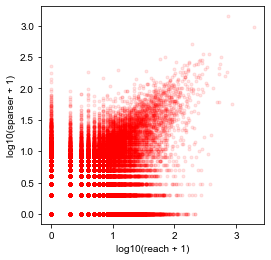

In [74]:
# Figure 2: Scatter plot of mention counts from Reach and Sparser.
def rand_jitter(arr, jitter=0.01):
    stdev = jitter * (max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def reader_corr_plot(count_df, reader1, reader2, jitter=0.01, logscale=True):
    plt.figure(figsize=(4, 4))
    #kge_cp  = count_df[(kge_df[reader1] > 0) | (kge_df[reader2] > 0)]
    if logscale:
        r1_counts = np.log10(count_df[reader1] + 1)
        r2_counts = np.log10(count_df[reader2] + 1)
        xlabel = f'log10({reader1} + 1)'
        ylabel = f'log10({reader2} + 1)'        
    else:
        r1_counts = count_df[reader1].values
        r2_counts = count_df[reader2].values
        xlabel = reader1
        ylabel = reader2    
    plt.plot(rand_jitter(r1_counts, jitter),
             rand_jitter(r2_counts, jitter), linestyle='', marker='.',
             color='red', alpha=0.1, label='Correct')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.legend(loc='upper left', frameon=False)
    #plt.figtext(0.5, 0.01, "A figure legend.", wrap=True, horizontalalignment='center', fontsize=14)
    plt.show()

reader_corr_plot(reader_counts, 'reach', 'sparser', jitter=0, logscale=True)

In [75]:
# Table 4: Mention correlations after filtering out two outlying points with many mentions.
outliers = reader_counts[reader_counts['sparser'] > 800]
outlier_filt = reader_counts.drop(outliers.index)
outlier_filt[reader_list].corr()

,reach,sparser,medscan,rlimsp,trips
reach,1.000000,0.550781,0.548421,0.080636,0.325913
sparser,0.550781,1.000000,0.364867,0.132939,0.332754
medscan,0.548421,0.364867,1.000000,0.037220,0.290822
rlimsp,0.080636,0.132939,0.037220,1.000000,0.100157
trips,0.325913,0.332754,0.290822,0.100157,1.000000


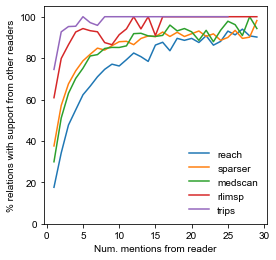

In [76]:
# Figure 3: Reader overlap as a function of mentions.
def plot_joint_vs_reader_count(count_df, reader_list):
    plt.figure(figsize=(4, 4))
    for reader in reader_list:
        count_df = reader_counts
        other_readers = [r for r in reader_list if r != reader]
        x_vals = []
        y_vals = []
        for reader_count in range(1, 30):
            recs_for_count = count_df[count_df[reader] == reader_count]
            if recs_for_count.shape[0] == 0:
                continue
            x_vals.append(reader_count)
            y_vals.append(100*recs_for_count[other_readers].any(1).mean())
        plt.plot(x_vals, y_vals, label=reader)
    plt.xlabel(f'Num. mentions from reader')
    plt.ylabel(f'% relations with support from other readers')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(0, 105)
    plt.show()

plot_joint_vs_reader_count(reader_counts, reader_list)

When mention counts were ignored and only the binary presence/absence of reader support was considered, correlations were small or moderately negative, because the readers contribute separately to the overall corpus but with little overlap on average (Table 5; also Table 1, Figure 1). This is most easily understood for the simplest case of a corpus with output from only two readers, where all correlations would be less than or equal to zero. If the readers were fully complementary (one reader yielding 1 for the other's 0 and vice versa) the correlation would clearly be -1; on the other hand, if the readers were in total agreement (produced identical output), the dataset would contain no zeros at all (because the corpus contains only relations with support from at least one reader) and hence the variances, covariances and correlations would all be zero.

In our dataset with five readers, the readers which produced the majority of the relations (Reach, Sparser, and Medscan) had only negative correlations with each other (Table 5), because the majority of their output was supported by one or two mentions (Table 6), and lacked overlap with other readers (Table 7). RLIMS-P and TRIPS exhibited positive correlations with other readers at the relation level, due to the fact that a large proportion of their overall smaller number of extractions overlapped with extractions from other readers (Table 7).

In [77]:
# Table 5: Correlations among readers at the relation level
bin_reader_counts = binarize_count_data(reader_counts)
bin_reader_counts[reader_list].corr()

,reach,sparser,medscan,rlimsp,trips
reach,1.000000,-0.241753,-0.474403,-0.020938,-0.015515
sparser,-0.241753,1.000000,-0.128048,0.078555,0.111548
medscan,-0.474403,-0.128048,1.000000,-0.010978,0.047709
rlimsp,-0.020938,0.078555,-0.010978,1.000000,0.069556
trips,-0.015515,0.111548,0.047709,0.069556,1.000000


In [78]:
# Table 6: Proportion of relations from each reader with 1 or >1 mentions.
def one_or_more_mentions(reader_counts, reader_list):
    nz = reader_counts[reader_list].apply(lambda x: x > 0, axis=0).sum()
    one = reader_counts[reader_list].apply(lambda x: x == 1, axis=0).sum()
    multi = reader_counts[reader_list].apply(lambda x: x > 1, axis=0).sum()
    one_ser = one / nz
    multi_ser = multi / nz
    one_ser.name = '=1 mention'
    multi_ser.name = '>1 mentions'
    return pd.concat([one_ser, multi_ser], axis=1)

one_or_more_mentions(reader_counts, reader_list)

,=1 mention,>1 mentions
reach,0.675077,0.324923
sparser,0.618371,0.381629
medscan,0.711481,0.288519
rlimsp,0.636058,0.363942
trips,0.833957,0.166043


In [79]:
# Table 7: Proportion of relations with overlap with other readers
def overlap_or_not(reader_counts, reader_list):
    col_names = ["No overlap", "Overlap"]
    no_ovl_data = []
    ovl_data = []
    for reader in reader_list:
        other_readers = [r for r in reader_list if r != reader]
        r_df = reader_counts[reader_counts[reader] != 0]
        overlap_pct = r_df[other_readers].any(1).mean()
        ovl_data.append(overlap_pct)
        no_ovl_data.append(1 - overlap_pct)
    return pd.DataFrame(zip(no_ovl_data, ovl_data), index=reader_list, columns=col_names)

overlap_or_not(reader_counts, reader_list)

,No overlap,Overlap
reach,0.724879,0.275121
sparser,0.501262,0.498738
medscan,0.610968,0.389032
rlimsp,0.300823,0.699177
trips,0.222587,0.777413


### Relation correctness as a function of reader overlap

We then examined the relationship between reader overlap and reader correctness using our manually curated dataset. At the mention level, statements supported by many mentions were both more likely to overlap with other readers and to be scored as correct (Figure 4). Notably, we found that for Reach, the reader with the most extensive subset of curated relations, the probability of relation correctness went up with the overall number of Reach mentions, but only for high-mention statements that also included support from other readers. For relations with support only from Reach, probability of correctness went up from 1 to 2 mentions, but additional Reach-only mentions were not associated with any further increase in precision (Figure 5).

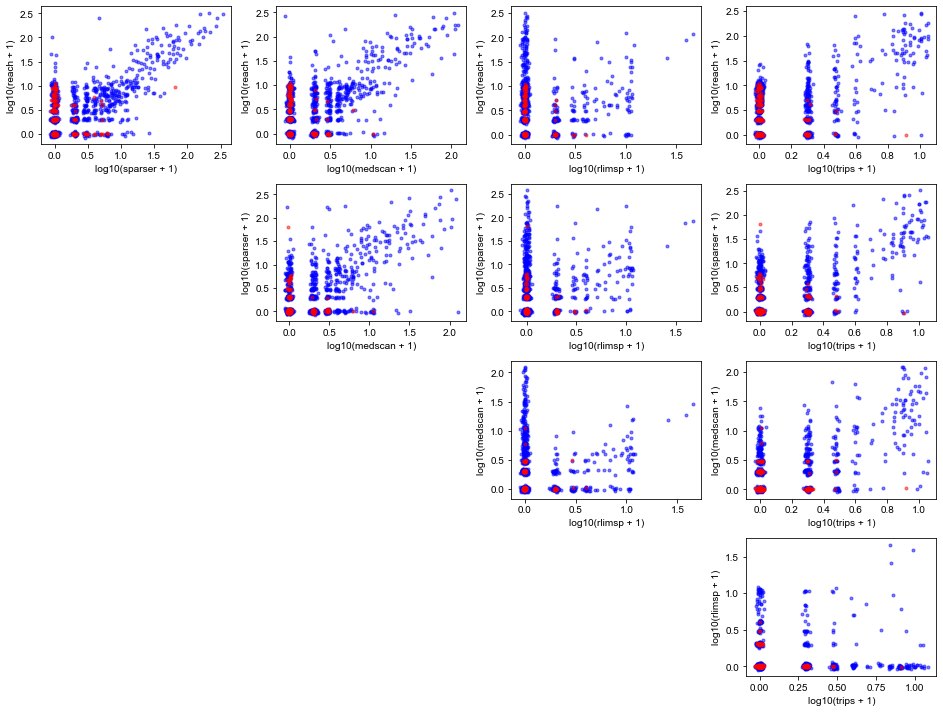

In [80]:
# Figure 4: Statement overlap at mention level and probability of correctness.
def plot_overlap_correctness(count_df, readers):
    r_pairs = list(itertools.product(readers, readers))
    plotted = set()
    plt.figure(figsize=(16, 10))
    n_rows = len(readers) - 1
    n_cols = len(readers)
    for i, (reader1, reader2) in enumerate(r_pairs):
        fs_readers = frozenset((reader1, reader2))
        if reader1 == reader2 or fs_readers in plotted:
            continue
        plotted.add(fs_readers)
        plt.subplot(n_rows, n_cols, i+1)
        incorr = count_df[count_df['correct'] == 0]
        corr = count_df[count_df['correct'] == 1]
        for df, color, label in ((corr, 'blue', 'Correct'),
                                 (incorr, 'red', 'Incorrect')):
            r1_counts = np.log10(df[reader1] + 1)
            r2_counts = np.log10(df[reader2] + 1)
            plt.plot(rand_jitter(r2_counts),
                     rand_jitter(r1_counts), linestyle='', marker='.',
                     color=color, alpha=0.5, label=label)
        plt.xlabel(f'log10({reader2} + 1)')
        plt.ylabel(f'log10({reader1} + 1)')
    #plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plot_overlap_correctness(kge_df, reader_list)

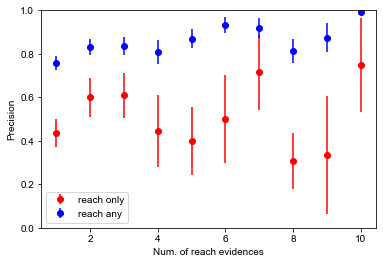

In [17]:
# Figure 5: Correctness vs. Reach mentions with and without reader overlap
def reader_corr_vs_overlap(ct_df, reader):
    source_cols = ['medscan', 'reach', 'sparser', 'rlimsp', 'trips', 'hprd', 'isi',
                   'biopax', 'bel', 'signor', 'trrust']
    source_cols.pop(source_cols.index(reader))
    # Reader only dataframe
    ro_df = ct_df[~ct_df[source_cols].any(axis=1)]
    x = list(range(1, 11))
    r_only = []
    r_all = []
    r_only_cts = []
    r_all_cts = []

    def stderrp(p, n):
        pa = np.array(p)
        na = np.array(n)
        return(np.sqrt((pa*(1-pa))/na))

    for i in x:
        lb = i
        if i < 10:
            ub = i+1
        else:
            ub = 10000

        r_only_rows = ro_df[(ro_df[reader] >= lb) & (ro_df[reader] < ub)]
        r_only.append(r_only_rows['correct'].mean())
        r_only_cts.append(len(r_only_rows['correct']))
        r_all_rows = kge_df[(kge_df[reader] >= lb) & (kge_df[reader] < ub)]
        r_all.append(r_all_rows['correct'].mean())
        r_all_cts.append(len(r_all_rows['correct']))

    plt.figure()
    plt.errorbar(x, r_only, linestyle='', yerr=stderrp(r_only, r_only_cts), marker='o', color='r', label=f'{reader} only')
    plt.errorbar(x, r_all, linestyle='', yerr=stderrp(r_all, r_all_cts), marker='o', color='b', label=f'{reader} any')
    plt.legend(loc='lower left')
    plt.ylabel('Precision')
    plt.xlabel(f'Num. of {reader} evidences')
    plt.ylim([0, 1])
reader_corr_vs_overlap(kge_df, 'reach')

### Propagating Belief: relation correctness as a function of statement relations

We then looked at how the probability of statement correctness 

In [167]:
# Collect all statements that are supported by statements that were already curated.
all_stmts_dict = {stmt.get_hash(): stmt for stmt in all_stmts}
#linked_stmts = []
supp_hashes = {}
sample_k = 100
random.seed(1) # For reproducibility in sampling
for correct_val in (0, 1):
    stmt_hashes = kge_df[kge_df.correct == correct_val].stmt_hash.values
    supp_by_stmts = [sb_stmt for stmt_hash in stmt_hashes
                                 for sb_stmt in all_stmts_dict[stmt_hash].supported_by
                                 if None not in sb_stmt.agent_list()]    
    supp_stmts = [sb_stmt for stmt_hash in stmt_hashes
                              for sb_stmt in all_stmts_dict[stmt_hash].supports
                              if None not in sb_stmt.agent_list()]
    supp_hashes[correct_val] = {'supports': [s.get_hash() for s in supp_stmts],
                                'supported_by': [s.get_hash() for s  in supp_by_stmts]}
    """
    supp_by_hashes_not_none = set([s.get_hash() for s in supp_by_stmts_raw if None not in s.agent_list()])
    supp_hashes_not_none = set([s.get_hash() for s in supp_stmts_raw if None not in s.agent_list()])
    supp_by_stmts = [all_stmts_dict[h] for h in supp_by_hashes_not_none]
    supp_stmts = [all_stmts_dict[h] for h in supp_hashes_not_none]
    """
    """
    if len(supp_stmts) > sample_k:
        supp_stmts = random.sample(supp_stmts, sample_k)
    if len(supp_by_stmts) > sample_k:
        supp_by_stmts = random.sample(supp_by_stmts, sample_k)
    """
    #ac.dump_statements(supp_stmts, f'bioexp_supp_stmts_corr{correct_val}.pkl')
    #ac.dump_statements(supp_by_stmts, f'bioexp_supp_by_stmts_corr{correct_val}.pkl')
    print("correct", correct_val, "supp_by", len(supp_by_stmts))
    print("correct", correct_val, "supp", len(supp_stmts))
    

correct 0 supp_by 42
correct 0 supp 78
correct 1 supp_by 518
correct 1 supp 1533


In [177]:
# Get the curations for the supports/supported_by statements
refinement_data_file  = 'refinement_dataset.pkl'
ref_df = load_curation_data(refinement_data_file)

In [178]:
supp_df_hashes = set(ref_df.stmt_hash.values)
for correct_val, supp_dict in supp_hashes.items():
    for supp_type, hash_list in supp_dict.items():
        num_curated = len(set(hash_list).intersection(supp_df_hashes))
        print(f"Correct {correct_val}, {supp_type}: {num_curated} / {len(hash_list)}")
        

Correct 0, supports: 77 / 78
Correct 0, supported_by: 41 / 42
Correct 1, supports: 67 / 1533
Correct 1, supported_by: 107 / 518


In [170]:
77 + 41 + 67 +107

292

### Comparison of approaches to predict correctness at the relation level

Using our curated dataset, we evaluated several types of models for their ability discriminate between correct and incorrect relations. We used both the unweighted curation dataset and a resampled dataset where the distribution of reader combinations was drawn from the full relation corpus and the class (correctness) was sampled from the subset of entries in the curation dataset for that combination. To establish an upper limit of performance we used a classifier with access to the exact probabilities of correctness for each reader combination from the full dataset (both training and test). The other models included a Logistic Regression model, Random Forest, Bernoulli Naive Bayes, Belief, and a second-order approximation of the joint probability distribution (BL2).

In [104]:
# Resample the curation data to match reader frequency distribution
def resample_curation_data(all_ev_ctr_dict, df_ev_dict, df_subgroup_dict,
                           tgt_size=30000, sampling='weighted'):
    """Generate a new dataset by resampling from curation dataset.
    
    Parameters
    ----------
    sampling : str
        Type of sampling, 'uniform' or 'weighted'. If uniform, all reader combinations
        are equally represented. If 'weighted' (default), follows frequency distribution from
        all_ev_ctr_dict. 
    """
    # Uniform sampling
    if sampling == 'uniform':
        tgt_frac = 1 / len(df_ev_dict)
        all_ev_adj_dict = {}
        for ev_combo in df_ev_dict:
            all_ev_adj_dict[ev_combo] = tgt_frac
    # Resample proportions from the original corpus to allow only those combos found in the
    # curation dataset
    else:
        adjust_total = 0
        for k, v in all_ev_ctr_dict.items():
            if k in df_ev_dict:
                adjust_total += v
            else:
                print(f"{k} not yet curated. Freq in corpus {v}.")
        all_ev_adj_dict = {k: (v/adjust_total) for k, v in all_ev_ctr_dict.items() if k in df_ev_dict}
        # Note that the adjusted dictionary only accounts for 80% of the statement evidence combinations
        # in the original dataset
        print("Adjusted total percentage:", adjust_total)

    # Now, iterate over each combination, determine how many records from the curation dataset
    # we need to sample based on the target proportion and overall dataset sizes.
    # Build up a list of Dataframes, one for each evidence combination, which we then concatenate
    # together at the end.
    tgt_counts = {}
    df_samples = []
    frac_counts = {}
    # Iterate over the reader combos in the curated data
    for ev_combo in df_ev_dict:
        # Get the target resampled count for this combination
        tgt_count = int(all_ev_adj_dict[ev_combo] * tgt_size)
        # If the tgt_count rounds down to 0, round up to 1.
        if tgt_count == 0:
            tgt_count = 1
        # Save the count for this reader combo
        tgt_counts[ev_combo] = tgt_count
        # FIXME TODO
        ev_combo_df = df_subgroup_dict[ev_combo]
        # Sample tgt_count entries with replacement from the subset of 
        # curation data for this reader combo
        df_samples.append(ev_combo_df.sample(tgt_count, replace=True))
    resampled_df = pd.concat(df_samples, ignore_index=True)
    return resampled_df

resampled_df = resample_curation_data(reader_freqs, curation_freqs, curation_dfs,
                                      tgt_size=30000, sampling='weighted')

('_', '_', 'M', 'P', 'T') not yet curated. Freq in corpus 1.985753636056747e-05.
Adjusted total percentage: 0.9999801424636393


In [106]:
# Function for calculating exact conditional probabilities
def prob(v, c=None, df=None):
    """Probability of variables v: vals conditioned on variables c: vals"""
    if df is None:
        raise ValueError("df must be given.")
    if c is None:
        c = []
    if not v:
        raise ValueError("v variables must be specified")
    c_df = df
    for c_var, c_val in c:
        c_df = c_df[c_df[c_var] == c_val]
    # Handle the case where the conditional event does not occur
    if len(c_df) == 0:
        return 0
    vc_df = None
    for v_var, v_val in v:
        if vc_df is None:
            vc_df = c_df[c_df[v_var] == v_val]
        else:
            vc_df = vc_df[vc_df[v_var] == v_val]
    return len(vc_df) / len(c_df)

In [107]:
# Implementations of Exact probability, Belief scores, and BL Expansions as sklearn models.
class BLPredictor(object):
    # The notation/nomenclature in the functions below here is based on page 3 of
    # "Estimation in second order dependency model for multivariate binary data", E.H.S. Ip.
    # Link [here](https://statistics.stanford.edu/sites/g/files/sbiybj6031/f/OLK%20NSF%20302.pdf). 
    def __init__(self, df=None, order=2):
        self.df = df
        self.order = order
        
    def fit(self, x_train, y_train, y_target=1):
        data = np.column_stack([x_train, y_train])
        self.y_ix = data.shape[1]-1
        self.df = pd.DataFrame(data)
        self.prob_cache = {}
        self.y_target = y_target
        # Get the unique input vectors in x_train
        x_val_combos_in_data = set([tuple(x_train[ix, :]) for ix in range(x_train.shape[0])])
        x_val_combos = list(itertools.product([0, 1], repeat=self.df.shape[1]-1))
        for x_vals in x_val_combos:
            # If this combination doesn't actually occur, set to NaN in the cache and skip
            if x_vals not in x_val_combos_in_data:
                self.prob_cache[x_vals] = np.nan
                continue
            x_vect = list(x_vals) + [y_target]
            col_vals = list(zip(range(len(x_vect)), x_vect))
            joint_prob = self.bahadur_laz(col_vals, max_order=self.order)
            denom = prob(col_vals[:-1], df=self.df)
            pred_prob = joint_prob / denom
            if pred_prob > 1:
                pred_prob = 1.0
            elif pred_prob < 0:
                pred_prob = 0.
            self.prob_cache[x_vals] = pred_prob
        
    def predict_proba(self, x_arr, order=2, threshold=0.5):
        if x_arr.shape[1] != self.df.shape[1] - 1:
            raise ValueError("Prediction data is wrong shape.")
        y_probs = np.zeros((x_arr.shape[0], 2))
        for row_ix in range(x_arr.shape[0]):
            x_vals = x_arr[row_ix, :]
            # Get the computed value for this feature vector from the cache
            pred_prob = self.prob_cache[tuple(x_vals)]
            # If we didn't see it in training, we just fall back on p(correct)
            if pred_prob is np.nan: 
                pred_prob = prob([(len(x_vals)-1, self.y_target)], df=self.df)
            y_probs[row_ix, 0] = 1 - pred_prob
            y_probs[row_ix, 1] = pred_prob
        return y_probs
    
    def predict(self, x_arr, order=2, threshold=0.5):
        if x_arr.shape[1] != self.df.shape[1] - 1:
            raise ValueError("Prediction data is wrong shape.")
        y_probs = np.zeros((x_arr.shape[0], 2))
        y_preds = self.predict_proba(x_arr, order, threshold)
        for row_ix, pred_prob in enumerate(y_preds):
            if pred_prob[1] is np.nan:
                pred = np.nan
            else:
                pred = 0 if pred_prob[1] < threshold else 1
            y_preds[row_ix] = pred
        return y_preds

    # alpha(Yi) = E(Yi), i.e., probability Yi = 1, i.e., p in the usual notation for bernoulli variables.
    def alpha(self, col):
        return self.df[col].mean()

    # This function returns the probability  p(Y1 = y1, Y2=y2, Y3=y3...) etc. as the product of
    # the independent probabilities i.e., p(Y1=y1)*p(Y2=y2)*p(Y3=y3)*...
    def p1y(self, col_vals):
        prod = 1
        for col, val in col_vals:
            if val not in (0, 1):
                raise ValueError("Values must be 0 or 1")
            prod *= (self.alpha(col)**val) * (1 - self.alpha(col))**(1 - val)
        return prod

    # W has two senses in the notation used by Ip. If no value is given (val=None),
    # evaluates to (Yi - p)/sqrt(pq) = a standardized version of Yi (offset by the mean and divided by the SD).
    # If given a specific value yi (0 or 1), gives the standardized probability of yi.
    def W(self, col, val=None):
        a = self.alpha(col)
        denom = np.sqrt(a * (1 - a))
        if val is None:
            numer = (self.df[col] - a).values
        else:
            numer = val - a
        return numer / denom

    # Returns E(W1*W2*...*Wi). For the case of two variables Yi and Yj, r_ij = E(Wi*Wj) is
    # equivalent to the correlation between Yi and Yj.
    def r(self, cols):
        return np.mean(np.prod(np.stack([self.W(col) for col in cols]), axis=0))

    # For a set of values associated with variables, i.e., y1, y2, ... yn,
    # returns the product W(y1)*W(y2)*...*W(yn), i.e., the product of the normalized
    # probabilities of each Yi taking a specific value yi.
    def W_prod(self, col_vals):
        return np.prod([self.W(col, val) for col, val in col_vals])

    # Generates a term in the expansion of the given order. For order 2,
    # returns sum_(j<k) {rjk * Wj * Wk}, i.e., based on pairwise correlations.
    def term(self, col_vals, order):
        total = 0
        for col_val_combo in itertools.combinations(col_vals, order):
            r_term = self.r([col for col, val in col_val_combo])
            W_term = self.W_prod(col_val_combo)
            total += r_term * W_term
        return total

    def bahadur_laz(self, col_vals, max_order=2):
        fy = 1
        if max_order < 1 or max_order > len(self.df.columns):
            raise ValueError('max_order must be between 1 and len(col_vals)')
        for order in range(2, max_order+1):
            fy += self.term(col_vals, order)
        return self.p1y(col_vals) * fy    

    
class ProbPredictor(BLPredictor):
    def fit(self, x_train, y_train, y_target=1):
        data = np.column_stack([x_train, y_train])
        self.y_ix = data.shape[1]-1
        self.df = pd.DataFrame(data)
        self.prob_cache = {}
        self.y_target = y_target
        # Get the unique input vectors in x_train
        x_val_combos_in_data = set([tuple(x_train[ix, :]) for ix in range(x_train.shape[0])])
        x_val_combos = list(itertools.product([0, 1], repeat=self.df.shape[1]-1))
        for x_vals in x_val_combos:
            # If this combination doesn't actually occur, set to NaN in the cache and skip
            if x_vals not in x_val_combos_in_data:
                self.prob_cache[x_vals] = np.nan
                continue
            x_vect = list(x_vals) + [y_target]
            col_vals = list(zip(range(len(x_vect)), x_vect))
            pred_prob = prob(col_vals, col_vals[:-1], df=self.df)
            self.prob_cache[x_vals] = pred_prob
    
    
class BeliefPredictor(BLPredictor):
    def fit(self, x_train, y_train, y_target=1):
        data = np.column_stack([x_train, y_train])
        self.y_ix = data.shape[1]-1
        self.df = pd.DataFrame(data)
        self.prob_cache = {}
        self.y_target = y_target
        # Calculate the error probabilities for each reader column
        err_probs = {}
        for col_ix in range(self.df.shape[1]-1):
            err_probs[col_ix] = 1 - self.df[self.df[col_ix] == 1][self.y_ix].mean()
        # Here, we actually iterate over all combinations of input vectors and compute belief
        x_val_combos = list(itertools.product([0, 1], repeat=self.df.shape[1]-1))
        for x_vals in x_val_combos:
            total_err_prob = 1
            for col_ix, x_val in enumerate(x_vals):
                # Multiply by the error probabilities for any readers with evidence
                if x_val == 1:
                    total_err_prob *= err_probs[col_ix]
            pred_prob = 1 - total_err_prob
            self.prob_cache[x_vals] = pred_prob

In [140]:
# Function to train different models
# Orphaned code
# Option 1: include stmt_type (encoded) and score
#df = kge_join.drop(columns=['stmt_hash', 'stmt_num', 'agA_name', 'agB_name'])
#le = LabelEncoder()
#le.fit(df.stmt_type)
#df.stmt_type = le.transform(df.stmt_type)

# Option 2: Only include binarized reader info
#reader_list = ['rlimsp', 'medscan', 'trips', 'reach', 'sparser']
#readers_to_include = ['reach', 'sparser']
# readers_to_include = reader_list

def eval_models_relation(model_dict, df, readers, split_func, test_split=0.2, num_folds=10,
                         cols_to_include=None):
    # Encode stmt_type
    df = df.copy()
    for col in ('agA_ns', 'agB_ns', 'stmt_type'):
        le = LabelEncoder()
        le.fit(df[col])
        df[col] = le.transform(df[col])
    # Filter to columns where at least one of the readers has an entry
    df = df[df[readers].any(1)]
    if cols_to_include is None:
        cols_to_include = readers + ['correct']
    df = df[cols_to_include] 
    print(cols_to_include)
    # Get dataset with int-encoded statement type and no class attribute (correct)
    x_df = df.drop('correct', axis=1)
    x = x_df.values
    # Class vector
    y = df.correct.values

    test_size = int(len(y) * test_split)
    # FIXME FIXME Make these parameters!

    predictors = {'': x, #'All features': x,
                  #'Without KGE': x[:, :-1], # Drop the score column
                  #'Only KGE': x[:, -1:]} # Only the score column
                 }

    clf_results = {}
    roc_results = {}
    roc_aucs= {}
    prec_results = {}
    rec_results = {}
    pr_aucs = {}
    # For each model...
    base_fpr = np.linspace(0, 1, 101)
    for clf_name, clf in model_dict.items():
        # Try different sets of features (predictors)...
        for pred_name, pred_x in predictors.items():
            # Fold the data multiple times
            # Save the data in a matrix (num_folds, test_size)
            tpr_arr = np.zeros((num_folds, len(base_fpr)))
            prec_arr = np.zeros((num_folds, len(base_fpr)))
            rec_arr = np.zeros((num_folds, len(base_fpr)))
            roc_auc_arr = np.zeros(num_folds)
            pr_auc_arr = np.zeros(num_folds)
            for fold_ix in tqdm(range(num_folds)):
                # Split the data
                x_train, x_test, y_train, y_test = split_func(pred_x, y, test_size=test_size)                
                # Train the model
                # ExactProb model gets all the data, both training and test
                if clf_name == 'ExactProb':
                    clf.fit(pred_x, y)
                else:
                    clf.fit(x_train, y_train)
                # Save the data
                clf_result = {}
                clf_result['y_preds'] = clf.predict(x_test)
                clf_result['y_probs'] = clf.predict_proba(x_test)

                # Compute ROC curve and ROC area for each model
                fpr, tpr, thresholds = roc_curve(y_test, clf_result['y_probs'][:, 1])
                roc_auc = auc(fpr, tpr)
                tpr_interp = interp(base_fpr, fpr, tpr)
                tpr_interp[0] = 0.0
                tpr_arr[fold_ix, :] = tpr_interp
                roc_auc_arr[fold_ix] = roc_auc
                # Precision/recall/thresholds for each model
                precision, recall, thresholds = precision_recall_curve(y_test, clf_result['y_probs'][:, 1])
                pr_auc = metrics.auc(recall, precision)
                pr_auc_arr[fold_ix] = pr_auc
                prec_arr[fold_ix, :] = interp(base_fpr, thresholds, precision[:-1])
                rec_arr[fold_ix, :] = interp(base_fpr, thresholds, recall[:-1])
            # Save the results for this model/predictor pair from all folds
            model_key = '%s %s' % (clf_name, pred_name)
            roc_results[model_key] = tpr_arr.mean(axis=0)
            clf_results[model_key] = clf_result
            roc_aucs[model_key] = roc_auc_arr
            prec_results[model_key] = prec_arr.mean(axis=0)
            rec_results[model_key] = rec_arr.mean(axis=0)
            pr_aucs[model_key] = pr_auc_arr
    return {'clf': clf_results,
            'roc': roc_results,
            'roc_auc': roc_aucs,
            'prec': prec_results,
            'rec': rec_results,
            'pr_auc': pr_aucs,
            'x_interp': base_fpr}

In [141]:
# Function to plot mean ROC from k-fold cross-validation
def plot_roc(results):
    plt.figure()
    lw = 2
    colors = ['r', 'g', 'b', 'orange', 'k', 'y', 'c', 'm']

    # Plot ROC curve for Belief Model (REACH)
    #plt.plot(bel_fpr, bel_tpr, color=colors[0],
    #         lw=lw, label='Orig. Belief (area = %0.2f)' % bel_roc_auc)
    roc_results = results['roc']
    roc_auc = results['roc_auc']
    for i, (clf_name, roc_result) in enumerate(roc_results.items()):
        roc_auc_arr = roc_auc[clf_name]
        plt.plot(results['x_interp'], roc_result, color=colors[i],
             lw=lw, label='%s (area = %0.2f +/- %0.2f)' %
                          (clf_name, roc_auc_arr.mean(), roc_auc_arr.std()))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [142]:
# Function to plot mean precision-recall curve from k-fold cross validation
def plot_prc(results):
    plt.figure()
    lw = 2
    colors = ['r', 'g', 'b', 'orange', 'k', 'y', 'c', 'm']
    for i, clf_name, in enumerate(results['prec']):
        prec_arr = results['prec'][clf_name]
        rec_arr = results['rec'][clf_name]
        pr_auc = results['pr_auc'][clf_name]                                   
        plt.plot(rec_arr, prec_arr, color=colors[i],
             lw=lw, label='%s (area = %0.2f +/- %0.2f)' %
                          (clf_name, pr_auc.mean(), pr_auc.std()))
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()    
 

In [143]:
# Function to compare predicted probabilities from various models to actual probabilities
def ev_to_reader_tuple(ev_tuple, reader_list, r_abbrevs):
    rtup = []
    for val, reader in zip(ev_tuple, reader_list):
        if val == 1:
            rtup.append(r_abbrevs[reader])
        else:
            rtup.append('_')
    return tuple(rtup)

def compare_probs(model_dict, reader_list, reader_abbrevs, stmt_freq_df, freq_col):
    df = None
    for model_name, model in model_dict.items():
        if model_name in ('Logistic Regression', 'Bernoulli Naive Bayes', 'Random Forest'):
            lr_probs = {}
            for ev_tuple in model_dict['ExactProb'].prob_cache.keys():
                lr_prob = model_dict[model_name].predict_proba([ev_tuple])[0][1]
                rtup = ev_to_reader_tuple(ev_tuple, reader_list, reader_abbrevs)
                lr_probs[rtup] = lr_prob
            lr_df = make_df(lr_probs, 'Readers', model_name)
            df = lr_df if df is None else df.join(lr_df)
        else:
            rtup_cache = {ev_to_reader_tuple(k, reader_list, reader_abbrevs): v
                          for k, v in model.prob_cache.items()}
            new_df = make_df(rtup_cache, 'Readers', model_name)
            df = new_df if df is None else df.join(new_df)
    df = df.join(stmt_freq_df)
    df = df.sort_values(by=freq_col, ascending=False)
    return df

In [144]:
models_rel = {
    'Belief': BeliefPredictor(),
    'ExactProb': ProbPredictor(),
    'Bernoulli Naive Bayes': BernoulliNB(),
    'Logistic Regression': LogisticRegression(),
    #'BL2': BLPredictor(order=2),
    #'BL6': BLPredictor(order=6),
    'Random Forest': RandomForestClassifier(),
}

#### Unweighted

  0%|          | 0/10 [00:00<?, ?it/s]

['reach', 'sparser', 'medscan', 'rlimsp', 'trips', 'correct']


100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


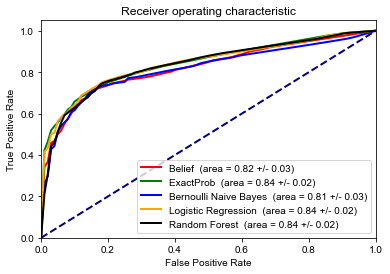

In [145]:
res_unweighted = eval_models_relation(models_rel, bin_df, reader_list, train_test_split,
                                      test_split=0.2, num_folds=10,
                                      cols_to_include=reader_list + ['correct'])
plot_roc(res_unweighted)

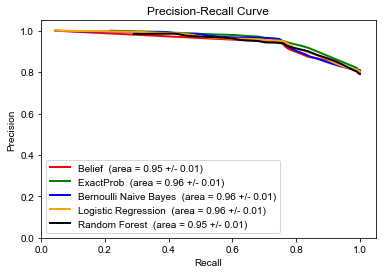

In [114]:
plot_prc(res_unweighted)

In [115]:
unwt_probs_df = compare_probs(models_rel, reader_list, reader_abbrevs, cur_freq_df, 'Curation Freq.')
unwt_probs_df

,Belief,ExactProb,Bernoulli Naive Bayes,Logistic Regression,Random Forest,Curation Freq.
Readers,,,,,,
"(R, _, _, _, _)",0.854133,0.502959,0.466475,0.553033,0.529546,0.156048
"(R, S, M, _, T)",0.999896,0.993464,0.989673,0.989523,1.000000,0.141274
"(R, _, M, _, _)",0.986184,0.936842,0.823759,0.873934,0.964540,0.087719
"(_, _, M, _, _)",0.905286,0.569767,0.643117,0.617724,0.618764,0.079409
"(R, S, M, _, _)",0.998930,1.000000,0.965902,0.955812,1.000000,0.061865
"(R, S, _, _, _)",0.988700,0.892308,0.841243,0.794266,0.904926,0.060018
"(_, _, _, _, T)",0.902821,0.655738,0.532806,0.557384,0.691727,0.056325
"(_, _, _, P, _)",0.903409,0.666667,0.487296,0.674943,0.678550,0.044321
"(R, S, _, P, _)",0.998909,0.947368,0.937267,0.965271,0.945353,0.035088


In [116]:
unwt_probs_df.corr('pearson')

,Belief,ExactProb,Bernoulli Naive Bayes,Logistic Regression,Random Forest,Curation Freq.
Belief,1.000000,0.841860,0.718977,0.754596,0.517469,-0.557409
ExactProb,0.841860,1.000000,0.786713,0.919807,0.972109,-0.372004
Bernoulli Naive Bayes,0.718977,0.786713,1.000000,0.919520,0.808996,-0.395720
Logistic Regression,0.754596,0.919807,0.919520,1.000000,0.892372,-0.416931
Random Forest,0.517469,0.972109,0.808996,0.892372,1.000000,-0.349034
Curation Freq.,-0.557409,-0.372004,-0.395720,-0.416931,-0.349034,1.000000


#### Weighted

100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


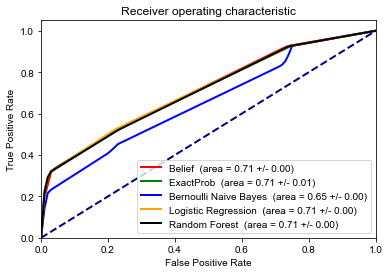

In [117]:
res_weighted = eval_models_relation(models_rel, resampled_df, reader_list, train_test_split,
                                    test_split=0.2, num_folds=10)
plot_roc(res_weighted)

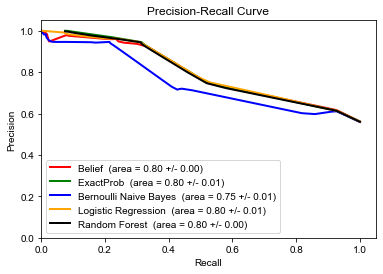

In [118]:
plot_prc(res_weighted)

In [119]:
wt_probs_df = compare_probs(models_rel, reader_list, reader_abbrevs, stmt_freq_df, 'Corpus Freq.')
wt_probs_df

,Belief,ExactProb,Bernoulli Naive Bayes,Logistic Regression,Random Forest,Corpus Freq.
Readers,,,,,,
"(R, _, _, _, _)",0.620213,0.500148,0.548234,0.500535,0.501634,0.449950
"(_, _, M, _, _)",0.723498,0.567818,0.631130,0.565330,0.573143,0.201791
"(_, S, _, _, _)",0.538312,0.270463,0.356661,0.291090,0.271989,0.153938
"(R, _, M, _, _)",0.894988,0.946520,0.767573,0.955700,0.946049,0.078537
"(R, S, _, _, _)",0.824657,0.899733,0.516920,0.871975,0.895073,0.049878
"(R, S, M, _, _)",0.951517,1.000000,0.744373,0.993226,1.000000,0.028466
"(_, S, M, _, _)",0.872342,1.000000,0.601383,0.898368,1.000000,0.010037
"(R, S, M, _, T)",0.992676,0.986928,0.923737,0.999358,0.983322,0.005133
"(_, _, _, _, T)",0.848936,0.613636,0.723396,0.390851,0.614253,0.004401


In [120]:
wt_probs_df.corr('spearman')

,Belief,ExactProb,Bernoulli Naive Bayes,Logistic Regression,Random Forest,Corpus Freq.
Belief,1.000000,0.731233,0.954545,0.950513,0.673011,-0.759677
ExactProb,0.731233,1.000000,0.640728,0.727984,0.911019,-0.617058
Bernoulli Naive Bayes,0.954545,0.640728,1.000000,0.891862,0.568970,-0.796371
Logistic Regression,0.950513,0.727984,0.891862,1.000000,0.747459,-0.581855
Random Forest,0.673011,0.911019,0.568970,0.747459,1.000000,-0.382218
Corpus Freq.,-0.759677,-0.617058,-0.796371,-0.581855,-0.382218,1.000000


#### Uniform

100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


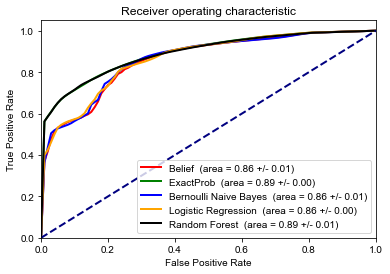

In [121]:
uniform_df = resample_curation_data(reader_freqs, curation_freqs, curation_dfs,
                                      tgt_size=30000, sampling='uniform')

res_uniform = eval_models_relation(models_rel, uniform_df, reader_list, train_test_split,
                                   test_split=0.2, num_folds=10)
plot_roc(res_uniform)

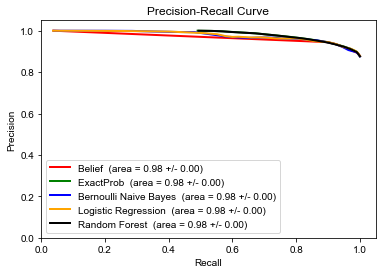

In [122]:
plot_prc(res_uniform)

In [123]:
uni_probs_df = compare_probs(models_rel, reader_list, reader_abbrevs, stmt_freq_df, 'ExactProb')
uni_probs_df

,Belief,ExactProb,Bernoulli Naive Bayes,Logistic Regression,Random Forest,Corpus Freq.
Readers,,,,,,
"(R, S, M, P, T)",0.999999,1.000,0.994785,0.999527,1.000000,0.000509
"(_, S, _, P, _)",0.996161,1.000,0.898834,0.904059,1.000000,0.000984
"(R, _, M, P, _)",0.999789,1.000,0.973658,0.989004,1.000000,0.000150
"(R, _, _, P, T)",0.999737,1.000,0.964004,0.984476,1.000000,0.000051
"(_, S, M, P, T)",0.999981,1.000,0.986466,0.997686,1.000000,0.000045
"(_, S, M, P, _)",0.999760,1.000,0.967634,0.986998,1.000000,0.000245
"(_, S, M, _, _)",0.994705,1.000,0.852547,0.865040,1.000000,0.010037
"(_, S, _, P, T)",0.999701,1.000,0.955872,0.981661,1.000000,0.000193
"(R, _, M, P, T)",0.999984,1.000,0.989025,0.998046,1.000000,0.000030


In [124]:
uni_probs_df.corr('pearson')

,Belief,ExactProb,Bernoulli Naive Bayes,Logistic Regression,Random Forest,Corpus Freq.
Belief,1.000000,0.908240,0.713492,0.726181,0.486176,-0.683671
ExactProb,0.908240,1.000000,0.901220,0.926536,0.999722,-0.653670
Bernoulli Naive Bayes,0.713492,0.901220,1.000000,0.987400,0.884220,-0.628154
Logistic Regression,0.726181,0.926536,0.987400,1.000000,0.901258,-0.692822
Random Forest,0.486176,0.999722,0.884220,0.901258,1.000000,-0.653527
Corpus Freq.,-0.683671,-0.653670,-0.628154,-0.692822,-0.653527,1.000000


### Comparison of approaches to predict correctness at the mention level

In [125]:
class BeliefModel(object):
    def __init__(self, reader_list, model_class=None, nwalkers=100,
                  burn_steps=100, sample_steps=100):
        if model_class is None:
            model_class = OrigBeliefStmt
        self.reader_list = reader_list
        self.model_class = model_class
        self.nwalkers = nwalkers
        self.burn_steps = burn_steps
        self.sample_steps = sample_steps
        self.reader_results = {}

    @staticmethod
    def df_to_num_ev(df):
        d = {}
        for _, num_ev, correct in df.itertuples():
            if num_ev not in d:
                d[num_ev] = []
            d[num_ev].append(correct)
        return d

    def fit(self, x_train, y_train, y_target=1):
        data = np.column_stack([x_train, y_train])
        self.y_ix = data.shape[1]-1
        self.y_target = y_target
        cols = self.reader_list + ['correct']
        df = pd.DataFrame(data, columns=cols)
        # Get the unique input vectors in x_train
        for reader in self.reader_list:
            r_df = df[df[reader] > 0][[reader, 'correct']]
            correct_by_num_ev = self.df_to_num_ev(r_df)
            # Convert the dataframe into a dictionary of corrects and incorrects keyed
            # by numbers of evidences
            print(reader, r_df.shape)
            model = OrigBeliefStmt()
            mf = ModelFit(model, correct_by_num_ev)
            with Pool() as pool:
                sampler = ens_sample(mf, self.nwalkers, self.burn_steps,
                                     self.sample_steps, pool=pool)
            self.reader_results[reader] = (mf, sampler)

    def predict_proba(self, x_arr):           
        y_probs = np.zeros((x_arr.shape[0], 2))
        reader_errs = np.zeros((x_arr.shape[0], len(reader_list)))
        for ix, reader in enumerate(self.reader_list):
            x_data = x_arr[:, ix]
            mf, sampler = self.reader_results[reader]
            map_params_dict = mf.get_map_params(sampler)
            params = [map_params_dict[pname] for pname in mf.model.param_names]
            reader_errs[:, ix] = mf.model.stmt_predictions(params, x_data)
        err_probs = 1 - reader_errs
        y_probs[:, 0] = err_probs.prod(axis=1)
        y_probs[:, 1] = 1 - y_probs[:, 0]
        return y_probs
    
    def predict(self, x_arr, threshold=0.5):
        y_preds = np.zeros(x_arr.shape[0])
        y_probs = self.predict_proba(x_arr)
        for row_ix, pred_prob in enumerate(y_probs):
            if pred_prob[1] is np.nan:
                pred = np.nan
            else:
                pred = 0 if pred_prob[1] < threshold else 1
            y_preds[row_ix] = pred
        return y_preds

In [126]:
class BeliefBayesModel(object):
    def __init__(self, df, ev_ub, reader_list, model_class=None, nwalkers=100,
                  burn_steps=100, sample_steps=100):
        if model_class is None:
            model_class = OrigBeliefStmt
        self.reader_list = reader_list
        self.model_class = model_class
        self.nwalkers = nwalkers
        self.burn_steps = burn_steps
        self.sample_steps = sample_steps
        self.reader_results = {}
        self.all_data = df
        self.ev_ub = ev_ub
        self.p_ri = {}
        self.p_ri_rj = {}
        self.p_c_r0 = {}
        
    @staticmethod
    def df_to_num_ev(df):
        d = {}
        for _, num_ev, correct in df.itertuples():
            if num_ev not in d:
                d[num_ev] = []
            d[num_ev].append(correct)
        return d

    def fit(self, x_train, y_train, y_target=1):
        data = np.column_stack([x_train, y_train])
        self.y_ix = data.shape[1]-1
        self.y_target = y_target
        cols = self.reader_list + ['correct']
        df = pd.DataFrame(data, columns=cols)
        # Run MCMC for each reader
        for reader in self.reader_list:
            r_df = df[df[reader] > 0][[reader, 'correct']]
            correct_by_num_ev = self.df_to_num_ev(r_df)
            # Convert the dataframe into a dictionary of corrects and incorrects keyed
            # by numbers of evidences
            print(reader, r_df.shape)
            model = OrigBeliefStmt()
            mf = ModelFit(model, correct_by_num_ev)
            with Pool() as pool:
                sampler = ens_sample(mf, self.nwalkers, self.burn_steps,
                                     self.sample_steps, pool=pool)
            self.reader_results[reader] = (mf, sampler)
        # Calculate p_correct from the training data only
        self.p_correct = np.mean(y_train)
        # Calculate p_c_r0
        for reader in self.reader_list:
            """
            # In principle this could be calculated given a model and 
            # an estimate of p(correct)
            mf, sampler = self.reader_results[reader]
            map_params_dict = mf.get_map_params(sampler)
            params = [map_params_dict[pname] for pname in mf.model.param_names]
            mf.model.stmt_predictions(params, x_data)
            for rd_ct, rd_ct_df in self.all_data.groupby(reader):
                if rd_ct == 0:
                    continue
            """
            self.p_c_r0[reader] = prob([('correct', 1)], [(reader, 0)], df=df)
        # Calculate reader marginal probabilities using all data
        n = len(self.all_data)
        for reader in reader_list:
            self.p_ri[reader] = {}
            for rd_ev, rd_ev_df in self.all_data.groupby(reader)[reader]:
                rd_ev_ct = rd_ev_df.count()
                self.p_ri[reader][rd_ev] = rd_ev_ct / n
        # Reader joint probabilities using all data
        for rd_cts, rd_df in self.all_data.groupby(self.reader_list)[reader_list]:
            self.p_ri_rj[rd_cts] = len(rd_df) / n

    def predict_proba(self, x_arr):           
        y_probs = np.zeros((x_arr.shape[0], 2))
        p_ri_c = np.zeros((x_arr.shape[0], len(reader_list)))
        p_c_ri = np.zeros((x_arr.shape[0], len(reader_list)))

        coeffs = np.zeros(x_arr.shape[0])
        # For each row, we need p(c) / p(R1,...,Rn)
        for i in range(x_arr.shape[0]):
            x_row = x_arr[i, :]
            joint_prob = self.p_ri_rj[tuple(x_row)]
            coeffs[i] = joint_prob
        coeffs = self.p_correct / coeffs
        # For each row, we need conditionally indep. estimates of p(c|Ri)
        for ix, reader in enumerate(self.reader_list):
            x_data = x_arr[:, ix]
            mf, sampler = self.reader_results[reader]
            map_params_dict = mf.get_map_params(sampler)
            params = [map_params_dict[pname] for pname in mf.model.param_names]
            p_c_ri[:, ix] = mf.model.stmt_predictions(params, x_data)
            p_c_ri[x_data == 0] = self.p_c_r0[reader]
        # For each row, we need p(Ri=ri) / p(c) for each reader
        for i in range(x_arr.shape[0]):
            for j, reader in enumerate(self.reader_list):
                p_ri_c[i, j] = self.p_ri[reader][x_arr[i, j]]
        p_ri_c = p_ri_c / self.p_correct
        p_ri_c = p_ri_c * p_c_ri
        probs = p_ri_c.prod(axis=1) * coeffs        
        #err_probs = 1 - reader_errs
        y_probs[:, 1] = probs
        y_probs[:, 0] = 1 - y_probs[:, 1]
        return y_probs
    
    def predict(self, x_arr, threshold=0.5):
        y_preds = np.zeros(x_arr.shape[0])
        y_probs = self.predict_proba(x_arr)
        for row_ix, pred_prob in enumerate(y_probs):
            if pred_prob[1] is np.nan:
                pred = np.nan
            else:
                pred = 0 if pred_prob[1] < threshold else 1
            y_preds[row_ix] = pred
        return y_preds

In [127]:
class LogLogisticRegression(LogisticRegression):
    def fit(self, x_train, y_train, *args, **kwargs):
        return super().fit(np.log(x_train+1), y_train, *args, **kwargs)
    
    def predict(self, x_arr, *args, **kwargs):
        return super().predict(np.log(x_arr+1), *args, **kwargs)
    
    def predict_proba(self, x_arr, *args, **kwargs):
        return super().predict_proba(np.log(x_arr+1), *args, **kwargs)
    
class BinaryRandomForest(RandomForestClassifier):
    @staticmethod
    def _binarize(x_arr):
        bin_arr = x_arr.copy()
        bin_arr[bin_arr > 0] = 1
        return bin_arr
        
    def fit(self, x_train, y_train, *args, **kwargs):
        return super().fit(self._binarize(x_train), y_train, *args, **kwargs)
    
    def predict(self, x_arr, *args, **kwargs):
        return super().predict(self._binarize(x_arr), *args, **kwargs)
    
    def predict_proba(self, x_arr, *args, **kwargs):
        return super().predict_proba(self._binarize(x_arr), *args, **kwargs)

In [128]:
def split_by_ev_ct(x_data, y_data, reader_list, low_ub=1, num_low=10, high_lb=8, num_high=10, test_size=None):
    data = np.column_stack([x_data, y_data])
    cols = reader_list + ['correct']
    df = pd.DataFrame(data, columns=cols)
    df_list = []
    for rdr in reader_list:
        # Get the row with evidence for this reader
        low_ev_rows = df[(df[rdr] > 0) & (df[rdr] <= low_ub)]
        high_ev_rows = df[df[rdr] > high_lb]
        low_samp = low_ev_rows.sample(num_low, replace=True)
        high_samp = high_ev_rows.sample(num_high, replace=True)
        df_list.extend([low_samp, high_samp])
    train_df = pd.concat(df_list).drop_duplicates()
    test_df = df[~df.index.isin(train_df.index)]
    x_train = train_df[reader_list].values
    y_train = train_df['correct'].values
    x_test = test_df[reader_list].values
    y_test = test_df['correct'].values
    return x_train, x_test, y_train, y_test

def split_closure(x_data, y_data, test_size):
    return split_by_ev_ct(x_data, y_data, reader_list, low_ub=1, num_low=5,
                          high_lb=8, num_high=5, test_size=test_size)

We note that the performance of all classifiers increases with the number of readers used. We measured AUROC and AUPRC of each classifier starting with data from 1 reader and increasing to 5 and not surprisingly found that both increased with additional readers. It is important to note though that this analysis was performed using the unweighted curation dataset which is biased towards high-mention statements with a higher likelihood of reader overlap.

In [129]:
def plot_aurocs(clf_aurocs, xticks, xticklabels, title, xlabel):
    plt.figure()
    for clf_name, aurocs in clf_aurocs.items():
        plt.errorbar(xticks, aurocs['mean'], yerr=aurocs['sd'], label=clf_name, marker='.')
    plt.legend(loc="lower right")
    plt.ylabel('AUROC')
    plt.title(title)
    plt.xticks(xticks)
    plt.xlabel(xlabel)
    ax = plt.gca()
    ax.set_xticklabels(xticklabels)
    plt.show()
    
def plot_auprcs(clf_auprcs, xticks, xticklabels, title, xlabel):
    plt.figure()
    for clf_name, auprcs in clf_auprcs.items():
        plt.errorbar(xticks, auprcs['mean'], yerr=auprcs['sd'], label=clf_name, marker='.')
    plt.legend(loc="lower right")
    plt.ylabel('AUPRC')
    plt.title(title)
    plt.xticks(xticks)
    plt.xlabel(xlabel)
    ax = plt.gca()
    ax.set_xticklabels(xticklabels)
    plt.show()

In [146]:
# ROC and PRC comparison for different models, using all data
#train_df = kge_df[reader_list + ['correct']]
models_ev = {
    'Logistic Regression': LogisticRegression(),
    'Log-Logistic Regression': LogLogisticRegression(),    
    'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
    #'Random Forest': RandomForestClassifier(),
    'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=4),
    'Belief Orig': BeliefModel(reader_list),
    #'Belief Binomial': BeliefModel(reader_subset, model_class=BinomialStmt),
    #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
    #                           nwalkers=100, burn_steps=100, sample_steps=100)
    #'GaussianNB': GaussianNB(),
}

res_ev = eval_models_relation(models_ev, kge_df, reader_list, train_test_split,
                              test_split=0.2, num_folds=10, cols_to_include=None)

  0%|          | 0/10 [00:00<?, ?it/s]

['reach', 'sparser', 'medscan', 'rlimsp', 'trips', 'correct']


  0%|          | 0/10 [00:00<?, ?it/s]


KeyboardInterrupt: 

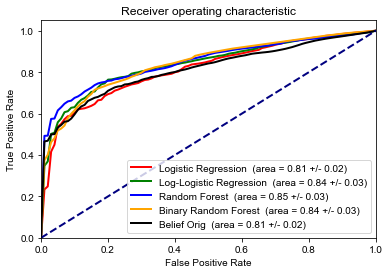

In [135]:
plot_roc(res_ev)

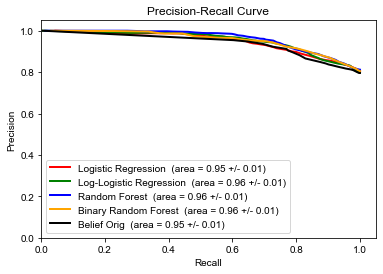

In [136]:
plot_prc(res_ev)

Now we give the dataset with supplementary evidences as well:

In [172]:
supp_df.columns

Index(['stmt_num', 'stmt_hash', 'agA_name', 'agA_ns', 'agA_id', 'stmt_type',
       'agB_name', 'agB_ns', 'agB_id', 'correct', 'reach', 'sparser',
       'medscan', 'trips', 'rlimsp', 'signor', 'bel', 'hprd', 'isi', 'biopax',
       'trrust'],
      dtype='object')

In [183]:
# ROC and PRC comparison for different models, using all data
#train_df = kge_df[reader_list + ['correct']]
models_ev = {
    'Logistic Regression': LogisticRegression(),
    'Log-Logistic Regression': LogLogisticRegression(),    
    'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
    #'Random Forest': RandomForestClassifier(),
    'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=4),
    #'Belief Orig': BeliefModel(reader_list),
    #'Belief Binomial': BeliefModel(reader_subset, model_class=BinomialStmt),
    #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
    #                           nwalkers=100, burn_steps=100, sample_steps=100)
    #'GaussianNB': GaussianNB(),
}

res_ev = eval_models_relation(models_ev, supp_df, reader_list, train_test_split,
                              test_split=0.2, num_folds=10,
                              cols_to_include=reader_list + ['num_supports', 'stmt_type', 'correct'])

  0%|          | 0/10 [00:00<?, ?it/s]

['reach', 'sparser', 'medscan', 'rlimsp', 'trips', 'num_supports', 'stmt_type', 'correct']


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


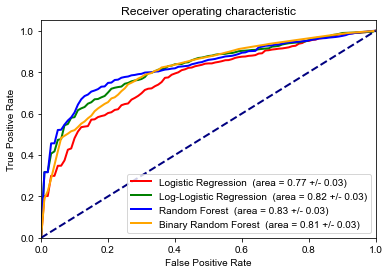

In [184]:
plot_roc(res_ev)

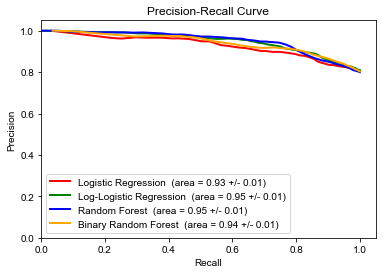

In [185]:
plot_prc(res_ev)

Now we give the other classifiers the statement type and agA/B namespaces as attributes:

In [147]:
# ROC and PRC comparison for different models, using all data
#train_df = kge_df[reader_list + ['correct']]
models_ev = {
    'Logistic Regression': LogisticRegression(),
    'Log-Logistic Regression': LogLogisticRegression(),    
    'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
    #'Random Forest': RandomForestClassifier(),
    'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=4),
    #'Belief Orig': BeliefModel(reader_list),
    #'Belief Binomial': BeliefModel(reader_subset, model_class=BinomialStmt),
    #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
    #                           nwalkers=100, burn_steps=100, sample_steps=100)
    #'GaussianNB': GaussianNB(),
}

res_ev = eval_models_relation(models_ev, kge_df, reader_list, train_test_split,
                              test_split=0.2, num_folds=10,
                              cols_to_include=reader_list + ['stmt_type', 'agA_ns', 'agB_ns', 'correct'])

  0%|          | 0/10 [00:00<?, ?it/s]

['reach', 'sparser', 'medscan', 'rlimsp', 'trips', 'stmt_type', 'agA_ns', 'agB_ns', 'correct']


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


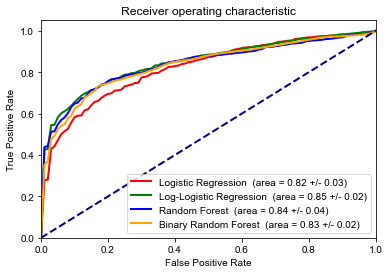

In [138]:
plot_roc(res_ev)

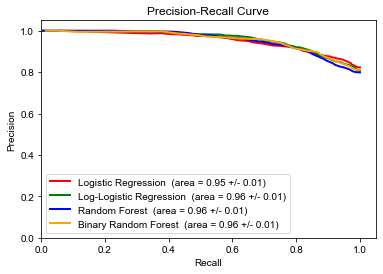

In [139]:
plot_prc(res_ev)

In [136]:
def adding_readers(reader_list, df, num_folds=10):
    clf_aurocs = {}
    clf_auprcs = {}
    for i in range(1, len(reader_list) + 1):
        reader_subset = reader_list[0:i]
        train_df = df[reader_subset + ['correct']]
        models_ev = {
            'Logistic Regression': LogisticRegression(),
            'Log-Logistic Regression': LogLogisticRegression(),    
            'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
            #'Random Forest': RandomForestClassifier(),
            'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=4),
            'Belief': BeliefModel(reader_subset),
            #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
            #                           nwalkers=100, burn_steps=100, sample_steps=100)
            #'GaussianNB': GaussianNB(),
        }
        
        res_ev = eval_models_relation(models_ev, train_df, reader_subset, train_test_split,
                                  test_split=0.2, num_folds=num_folds)
        roc_auc = res_ev['roc_auc']
        pr_auc = res_ev['pr_auc']
        for i, (clf_name, roc_auc_arr) in enumerate(roc_auc.items()):
            pr_auc_arr = pr_auc[clf_name]
            if clf_name not in clf_aurocs:
                clf_aurocs[clf_name] = {'mean': [], 'sd': []}
            clf_aurocs[clf_name]['mean'].append(roc_auc_arr.mean())
            clf_aurocs[clf_name]['sd'].append(roc_auc_arr.std())
            if clf_name not in clf_auprcs:
                clf_auprcs[clf_name] = {'mean': [], 'sd': []}
            clf_auprcs[clf_name]['mean'].append(pr_auc_arr.mean())
            clf_auprcs[clf_name]['sd'].append(pr_auc_arr.std())
    return (clf_aurocs, clf_auprcs)

In [137]:
def adding_data(num_low_high, reader_list, df, num_folds=10):
    clf_aurocs = {}
    clf_auprcs = {}
    
    for i, (num_low, num_high) in enumerate(num_low_high):
        train_df = df[reader_list + ['correct']]
        
        def split_closure(x_data, y_data, test_size):
            return split_by_ev_ct(x_data, y_data, reader_list, low_ub=1, num_low=num_low,
                                  high_lb=8, num_high=num_high, test_size=test_size)
        
        models_ev = {
            'Logistic Regression': LogisticRegression(),
            'Log-Logistic Regression': LogLogisticRegression(),    
            #'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
            #'Random Forest': RandomForestClassifier(),
            #'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=4),
            'Belief': BeliefModel(reader_subset),
            #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
            #                           nwalkers=100, burn_steps=100, sample_steps=100)
            #'GaussianNB': GaussianNB(),
        }
        res_ev = eval_models_relation(models_ev, train_df, reader_subset, split_closure,
                                      test_split=0.2, num_folds=num_folds)
        roc_auc = res_ev['roc_auc']
        pr_auc = res_ev['pr_auc']
        for i, (clf_name, roc_auc_arr) in enumerate(roc_auc.items()):
            pr_auc_arr = pr_auc[clf_name]
            if clf_name not in clf_aurocs:
                clf_aurocs[clf_name] = {'mean': [], 'sd': []}
            clf_aurocs[clf_name]['mean'].append(roc_auc_arr.mean())
            clf_aurocs[clf_name]['sd'].append(roc_auc_arr.std())
            if clf_name not in clf_auprcs:
                clf_auprcs[clf_name] = {'mean': [], 'sd': []}
            clf_auprcs[clf_name]['mean'].append(pr_auc_arr.mean())
            clf_auprcs[clf_name]['sd'].append(pr_auc_arr.std())
    return (clf_aurocs, clf_auprcs)

In [158]:
#num_low_high = [(3, 3), (5, 5), (8, 8), (12, 12), (17, 17), (25, 25), (100, 100), (1000, 1000)]
num_low_high = [(5, 5), (10, 10), (20, 20), (30, 30)]
ad_rocs, ad_prcs = adding_data(num_low_high, reader_list, kge_df, num_folds=10)

  0%|          | 0/10 [00:00<?, ?it/s]

reach (36, 2)


INFO: [2020-10-26 09:54:05] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:07] model_fit - Main sampling...
INFO: [2020-10-26 09:54:08] model_fit - Done sampling.


sparser (34, 2)


INFO: [2020-10-26 09:54:08] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:09] model_fit - Main sampling...
INFO: [2020-10-26 09:54:11] model_fit - Done sampling.


medscan (32, 2)


INFO: [2020-10-26 09:54:11] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:12] model_fit - Main sampling...
INFO: [2020-10-26 09:54:13] model_fit - Done sampling.


rlimsp (21, 2)


INFO: [2020-10-26 09:54:13] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:14] model_fit - Main sampling...
INFO: [2020-10-26 09:54:15] model_fit - Done sampling.


trips (28, 2)


INFO: [2020-10-26 09:54:16] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:17] model_fit - Main sampling...
INFO: [2020-10-26 09:54:18] model_fit - Done sampling.
 10%|█         | 1/10 [00:12<01:56, 12.91s/it]

reach (34, 2)


INFO: [2020-10-26 09:54:18] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:19] model_fit - Main sampling...
INFO: [2020-10-26 09:54:20] model_fit - Done sampling.


sparser (37, 2)


INFO: [2020-10-26 09:54:20] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:21] model_fit - Main sampling...
INFO: [2020-10-26 09:54:22] model_fit - Done sampling.


medscan (30, 2)


INFO: [2020-10-26 09:54:22] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:24] model_fit - Main sampling...
INFO: [2020-10-26 09:54:24] model_fit - Done sampling.


rlimsp (10, 2)


INFO: [2020-10-26 09:54:25] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:25] model_fit - Main sampling...
INFO: [2020-10-26 09:54:26] model_fit - Done sampling.


trips (30, 2)


INFO: [2020-10-26 09:54:26] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:27] model_fit - Main sampling...
INFO: [2020-10-26 09:54:28] model_fit - Done sampling.
 20%|██        | 2/10 [00:23<01:37, 12.22s/it]

reach (38, 2)


INFO: [2020-10-26 09:54:29] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:30] model_fit - Main sampling...
INFO: [2020-10-26 09:54:31] model_fit - Done sampling.


sparser (34, 2)


INFO: [2020-10-26 09:54:31] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:32] model_fit - Main sampling...
INFO: [2020-10-26 09:54:33] model_fit - Done sampling.


medscan (33, 2)


INFO: [2020-10-26 09:54:33] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:34] model_fit - Main sampling...
INFO: [2020-10-26 09:54:35] model_fit - Done sampling.


rlimsp (15, 2)


INFO: [2020-10-26 09:54:36] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:36] model_fit - Main sampling...
INFO: [2020-10-26 09:54:37] model_fit - Done sampling.


trips (29, 2)


INFO: [2020-10-26 09:54:37] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:38] model_fit - Main sampling...
INFO: [2020-10-26 09:54:39] model_fit - Done sampling.
 30%|███       | 3/10 [00:34<01:21, 11.70s/it]

reach (33, 2)


INFO: [2020-10-26 09:54:39] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:40] model_fit - Main sampling...
INFO: [2020-10-26 09:54:41] model_fit - Done sampling.


sparser (31, 2)


INFO: [2020-10-26 09:54:41] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:42] model_fit - Main sampling...
INFO: [2020-10-26 09:54:44] model_fit - Done sampling.


medscan (32, 2)


INFO: [2020-10-26 09:54:44] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:45] model_fit - Main sampling...
INFO: [2020-10-26 09:54:46] model_fit - Done sampling.


rlimsp (16, 2)


INFO: [2020-10-26 09:54:46] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:47] model_fit - Main sampling...
INFO: [2020-10-26 09:54:47] model_fit - Done sampling.


trips (24, 2)


INFO: [2020-10-26 09:54:48] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:48] model_fit - Main sampling...
INFO: [2020-10-26 09:54:49] model_fit - Done sampling.
 40%|████      | 4/10 [00:44<01:07, 11.30s/it]

reach (38, 2)


INFO: [2020-10-26 09:54:49] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:50] model_fit - Main sampling...
INFO: [2020-10-26 09:54:51] model_fit - Done sampling.


sparser (31, 2)


INFO: [2020-10-26 09:54:52] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:53] model_fit - Main sampling...
INFO: [2020-10-26 09:54:54] model_fit - Done sampling.


medscan (32, 2)


INFO: [2020-10-26 09:54:54] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:55] model_fit - Main sampling...
INFO: [2020-10-26 09:54:56] model_fit - Done sampling.


rlimsp (12, 2)


INFO: [2020-10-26 09:54:56] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:57] model_fit - Main sampling...
INFO: [2020-10-26 09:54:58] model_fit - Done sampling.


trips (26, 2)


INFO: [2020-10-26 09:54:58] model_fit - Burn in sampling...
INFO: [2020-10-26 09:54:59] model_fit - Main sampling...
INFO: [2020-10-26 09:55:00] model_fit - Done sampling.
 50%|█████     | 5/10 [00:55<00:55, 11.13s/it]

reach (40, 2)


INFO: [2020-10-26 09:55:00] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:01] model_fit - Main sampling...
INFO: [2020-10-26 09:55:03] model_fit - Done sampling.


sparser (33, 2)


INFO: [2020-10-26 09:55:03] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:04] model_fit - Main sampling...
INFO: [2020-10-26 09:55:05] model_fit - Done sampling.


medscan (33, 2)


INFO: [2020-10-26 09:55:05] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:06] model_fit - Main sampling...
INFO: [2020-10-26 09:55:07] model_fit - Done sampling.


rlimsp (14, 2)


INFO: [2020-10-26 09:55:07] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:08] model_fit - Main sampling...
INFO: [2020-10-26 09:55:09] model_fit - Done sampling.


trips (25, 2)


INFO: [2020-10-26 09:55:09] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:10] model_fit - Main sampling...
INFO: [2020-10-26 09:55:11] model_fit - Done sampling.
 60%|██████    | 6/10 [01:05<00:44, 11.02s/it]

reach (32, 2)


INFO: [2020-10-26 09:55:11] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:13] model_fit - Main sampling...
INFO: [2020-10-26 09:55:15] model_fit - Done sampling.


sparser (29, 2)


INFO: [2020-10-26 09:55:15] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:16] model_fit - Main sampling...
INFO: [2020-10-26 09:55:17] model_fit - Done sampling.


medscan (28, 2)


INFO: [2020-10-26 09:55:17] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:19] model_fit - Main sampling...
INFO: [2020-10-26 09:55:20] model_fit - Done sampling.


rlimsp (12, 2)


INFO: [2020-10-26 09:55:20] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:21] model_fit - Main sampling...
INFO: [2020-10-26 09:55:21] model_fit - Done sampling.


trips (24, 2)


INFO: [2020-10-26 09:55:22] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:23] model_fit - Main sampling...
INFO: [2020-10-26 09:55:24] model_fit - Done sampling.
 70%|███████   | 7/10 [01:18<00:34, 11.65s/it]

reach (40, 2)


INFO: [2020-10-26 09:55:24] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:25] model_fit - Main sampling...
INFO: [2020-10-26 09:55:27] model_fit - Done sampling.


sparser (35, 2)


INFO: [2020-10-26 09:55:27] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:29] model_fit - Main sampling...
INFO: [2020-10-26 09:55:31] model_fit - Done sampling.


medscan (30, 2)


INFO: [2020-10-26 09:55:31] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:32] model_fit - Main sampling...
INFO: [2020-10-26 09:55:33] model_fit - Done sampling.


rlimsp (18, 2)


INFO: [2020-10-26 09:55:34] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:35] model_fit - Main sampling...
INFO: [2020-10-26 09:55:35] model_fit - Done sampling.


trips (23, 2)


INFO: [2020-10-26 09:55:36] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:37] model_fit - Main sampling...
INFO: [2020-10-26 09:55:38] model_fit - Done sampling.
 80%|████████  | 8/10 [01:32<00:24, 12.32s/it]

reach (41, 2)


INFO: [2020-10-26 09:55:38] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:39] model_fit - Main sampling...
INFO: [2020-10-26 09:55:40] model_fit - Done sampling.


sparser (34, 2)


INFO: [2020-10-26 09:55:40] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:41] model_fit - Main sampling...
INFO: [2020-10-26 09:55:42] model_fit - Done sampling.


medscan (31, 2)


INFO: [2020-10-26 09:55:42] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:44] model_fit - Main sampling...
INFO: [2020-10-26 09:55:45] model_fit - Done sampling.


rlimsp (16, 2)


INFO: [2020-10-26 09:55:45] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:45] model_fit - Main sampling...
INFO: [2020-10-26 09:55:46] model_fit - Done sampling.


trips (31, 2)


INFO: [2020-10-26 09:55:46] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:47] model_fit - Main sampling...
INFO: [2020-10-26 09:55:49] model_fit - Done sampling.
 90%|█████████ | 9/10 [01:43<00:11, 11.91s/it]

reach (32, 2)


INFO: [2020-10-26 09:55:49] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:50] model_fit - Main sampling...
INFO: [2020-10-26 09:55:51] model_fit - Done sampling.


sparser (34, 2)


INFO: [2020-10-26 09:55:51] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:53] model_fit - Main sampling...
INFO: [2020-10-26 09:55:53] model_fit - Done sampling.


medscan (29, 2)


INFO: [2020-10-26 09:55:54] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:55] model_fit - Main sampling...
INFO: [2020-10-26 09:55:56] model_fit - Done sampling.


rlimsp (17, 2)


INFO: [2020-10-26 09:55:56] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:57] model_fit - Main sampling...
INFO: [2020-10-26 09:55:58] model_fit - Done sampling.


trips (26, 2)


INFO: [2020-10-26 09:55:58] model_fit - Burn in sampling...
INFO: [2020-10-26 09:55:59] model_fit - Main sampling...
INFO: [2020-10-26 09:56:00] model_fit - Done sampling.
  0%|          | 0/10 [00:00<?, ?it/s]

reach (64, 2)


INFO: [2020-10-26 09:56:01] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:02] model_fit - Main sampling...
INFO: [2020-10-26 09:56:04] model_fit - Done sampling.


sparser (61, 2)


INFO: [2020-10-26 09:56:04] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:05] model_fit - Main sampling...
INFO: [2020-10-26 09:56:07] model_fit - Done sampling.


medscan (61, 2)


INFO: [2020-10-26 09:56:07] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:09] model_fit - Main sampling...
INFO: [2020-10-26 09:56:10] model_fit - Done sampling.


rlimsp (24, 2)


INFO: [2020-10-26 09:56:10] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:11] model_fit - Main sampling...
INFO: [2020-10-26 09:56:13] model_fit - Done sampling.


trips (54, 2)


INFO: [2020-10-26 09:56:13] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:14] model_fit - Main sampling...
INFO: [2020-10-26 09:56:16] model_fit - Done sampling.
 10%|█         | 1/10 [00:15<02:16, 15.13s/it]

reach (71, 2)


INFO: [2020-10-26 09:56:16] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:17] model_fit - Main sampling...
INFO: [2020-10-26 09:56:19] model_fit - Done sampling.


sparser (72, 2)


INFO: [2020-10-26 09:56:19] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:21] model_fit - Main sampling...
INFO: [2020-10-26 09:56:22] model_fit - Done sampling.


medscan (61, 2)


INFO: [2020-10-26 09:56:23] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:24] model_fit - Main sampling...
INFO: [2020-10-26 09:56:26] model_fit - Done sampling.


rlimsp (36, 2)


INFO: [2020-10-26 09:56:26] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:27] model_fit - Main sampling...
INFO: [2020-10-26 09:56:29] model_fit - Done sampling.


trips (53, 2)


INFO: [2020-10-26 09:56:29] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:31] model_fit - Main sampling...
INFO: [2020-10-26 09:56:32] model_fit - Done sampling.
 20%|██        | 2/10 [00:31<02:03, 15.49s/it]

reach (56, 2)


INFO: [2020-10-26 09:56:32] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:34] model_fit - Main sampling...
INFO: [2020-10-26 09:56:35] model_fit - Done sampling.


sparser (56, 2)


INFO: [2020-10-26 09:56:35] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:37] model_fit - Main sampling...
INFO: [2020-10-26 09:56:38] model_fit - Done sampling.


medscan (55, 2)


INFO: [2020-10-26 09:56:38] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:39] model_fit - Main sampling...
INFO: [2020-10-26 09:56:41] model_fit - Done sampling.


rlimsp (28, 2)


INFO: [2020-10-26 09:56:41] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:42] model_fit - Main sampling...
INFO: [2020-10-26 09:56:44] model_fit - Done sampling.


trips (42, 2)


INFO: [2020-10-26 09:56:44] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:46] model_fit - Main sampling...
INFO: [2020-10-26 09:56:47] model_fit - Done sampling.
 30%|███       | 3/10 [00:46<01:47, 15.35s/it]

reach (65, 2)


INFO: [2020-10-26 09:56:47] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:49] model_fit - Main sampling...
INFO: [2020-10-26 09:56:50] model_fit - Done sampling.


sparser (62, 2)


INFO: [2020-10-26 09:56:50] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:52] model_fit - Main sampling...
INFO: [2020-10-26 09:56:53] model_fit - Done sampling.


medscan (58, 2)


INFO: [2020-10-26 09:56:54] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:55] model_fit - Main sampling...
INFO: [2020-10-26 09:56:57] model_fit - Done sampling.


rlimsp (30, 2)


INFO: [2020-10-26 09:56:57] model_fit - Burn in sampling...
INFO: [2020-10-26 09:56:58] model_fit - Main sampling...
INFO: [2020-10-26 09:56:59] model_fit - Done sampling.


trips (47, 2)


INFO: [2020-10-26 09:57:00] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:01] model_fit - Main sampling...
INFO: [2020-10-26 09:57:02] model_fit - Done sampling.
 40%|████      | 4/10 [01:01<01:31, 15.28s/it]

reach (70, 2)


INFO: [2020-10-26 09:57:02] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:04] model_fit - Main sampling...
INFO: [2020-10-26 09:57:05] model_fit - Done sampling.


sparser (63, 2)


INFO: [2020-10-26 09:57:05] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:07] model_fit - Main sampling...
INFO: [2020-10-26 09:57:08] model_fit - Done sampling.


medscan (60, 2)


INFO: [2020-10-26 09:57:09] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:10] model_fit - Main sampling...
INFO: [2020-10-26 09:57:12] model_fit - Done sampling.


rlimsp (31, 2)


INFO: [2020-10-26 09:57:12] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:13] model_fit - Main sampling...
INFO: [2020-10-26 09:57:14] model_fit - Done sampling.


trips (47, 2)


INFO: [2020-10-26 09:57:15] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:16] model_fit - Main sampling...
INFO: [2020-10-26 09:57:17] model_fit - Done sampling.
 50%|█████     | 5/10 [01:16<01:15, 15.14s/it]

reach (70, 2)


INFO: [2020-10-26 09:57:17] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:19] model_fit - Main sampling...
INFO: [2020-10-26 09:57:20] model_fit - Done sampling.


sparser (65, 2)


INFO: [2020-10-26 09:57:20] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:22] model_fit - Main sampling...
INFO: [2020-10-26 09:57:23] model_fit - Done sampling.


medscan (62, 2)


INFO: [2020-10-26 09:57:24] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:26] model_fit - Main sampling...
INFO: [2020-10-26 09:57:27] model_fit - Done sampling.


rlimsp (30, 2)


INFO: [2020-10-26 09:57:28] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:29] model_fit - Main sampling...
INFO: [2020-10-26 09:57:29] model_fit - Done sampling.


trips (48, 2)


INFO: [2020-10-26 09:57:30] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:31] model_fit - Main sampling...
INFO: [2020-10-26 09:57:32] model_fit - Done sampling.
 60%|██████    | 6/10 [01:31<01:00, 15.14s/it]

reach (67, 2)


INFO: [2020-10-26 09:57:32] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:34] model_fit - Main sampling...
INFO: [2020-10-26 09:57:35] model_fit - Done sampling.


sparser (61, 2)


INFO: [2020-10-26 09:57:35] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:37] model_fit - Main sampling...
INFO: [2020-10-26 09:57:38] model_fit - Done sampling.


medscan (55, 2)


INFO: [2020-10-26 09:57:39] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:40] model_fit - Main sampling...
INFO: [2020-10-26 09:57:42] model_fit - Done sampling.


rlimsp (29, 2)


INFO: [2020-10-26 09:57:42] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:43] model_fit - Main sampling...
INFO: [2020-10-26 09:57:44] model_fit - Done sampling.


trips (52, 2)


INFO: [2020-10-26 09:57:44] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:45] model_fit - Main sampling...
INFO: [2020-10-26 09:57:46] model_fit - Done sampling.
 70%|███████   | 7/10 [01:45<00:44, 14.89s/it]

reach (63, 2)


INFO: [2020-10-26 09:57:47] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:48] model_fit - Main sampling...
INFO: [2020-10-26 09:57:49] model_fit - Done sampling.


sparser (62, 2)


INFO: [2020-10-26 09:57:50] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:52] model_fit - Main sampling...
INFO: [2020-10-26 09:57:54] model_fit - Done sampling.


medscan (57, 2)


INFO: [2020-10-26 09:57:54] model_fit - Burn in sampling...
INFO: [2020-10-26 09:57:57] model_fit - Main sampling...
INFO: [2020-10-26 09:57:59] model_fit - Done sampling.


rlimsp (28, 2)


INFO: [2020-10-26 09:57:59] model_fit - Burn in sampling...
INFO: [2020-10-26 09:58:00] model_fit - Main sampling...
INFO: [2020-10-26 09:58:01] model_fit - Done sampling.


trips (51, 2)


INFO: [2020-10-26 09:58:01] model_fit - Burn in sampling...
INFO: [2020-10-26 09:58:03] model_fit - Main sampling...
INFO: [2020-10-26 09:58:04] model_fit - Done sampling.
 80%|████████  | 8/10 [02:03<00:31, 15.76s/it]

reach (77, 2)


INFO: [2020-10-26 09:58:04] model_fit - Burn in sampling...
INFO: [2020-10-26 09:58:06] model_fit - Main sampling...
INFO: [2020-10-26 09:58:08] model_fit - Done sampling.


sparser (67, 2)


INFO: [2020-10-26 09:58:09] model_fit - Burn in sampling...
INFO: [2020-10-26 09:58:11] model_fit - Main sampling...
INFO: [2020-10-26 09:58:13] model_fit - Done sampling.


medscan (68, 2)


INFO: [2020-10-26 09:58:13] model_fit - Burn in sampling...
INFO: [2020-10-26 09:58:15] model_fit - Main sampling...
INFO: [2020-10-26 09:58:17] model_fit - Done sampling.


rlimsp (30, 2)


INFO: [2020-10-26 09:58:17] model_fit - Burn in sampling...
INFO: [2020-10-26 09:58:18] model_fit - Main sampling...
INFO: [2020-10-26 09:58:19] model_fit - Done sampling.


trips (53, 2)


INFO: [2020-10-26 09:58:20] model_fit - Burn in sampling...
INFO: [2020-10-26 09:58:22] model_fit - Main sampling...
INFO: [2020-10-26 09:58:24] model_fit - Done sampling.
 90%|█████████ | 9/10 [02:23<00:16, 16.90s/it]

reach (67, 2)


INFO: [2020-10-26 09:58:24] model_fit - Burn in sampling...
INFO: [2020-10-26 09:58:26] model_fit - Main sampling...
INFO: [2020-10-26 09:58:28] model_fit - Done sampling.


sparser (69, 2)


INFO: [2020-10-26 09:58:28] model_fit - Burn in sampling...
INFO: [2020-10-26 09:58:30] model_fit - Main sampling...
INFO: [2020-10-26 09:58:31] model_fit - Done sampling.


medscan (62, 2)


INFO: [2020-10-26 09:58:31] model_fit - Burn in sampling...
INFO: [2020-10-26 09:58:33] model_fit - Main sampling...
INFO: [2020-10-26 09:58:34] model_fit - Done sampling.


rlimsp (27, 2)


INFO: [2020-10-26 09:58:34] model_fit - Burn in sampling...
INFO: [2020-10-26 09:58:35] model_fit - Main sampling...
INFO: [2020-10-26 09:58:36] model_fit - Done sampling.


trips (45, 2)


INFO: [2020-10-26 09:58:36] model_fit - Burn in sampling...
INFO: [2020-10-26 09:58:37] model_fit - Main sampling...
INFO: [2020-10-26 09:58:39] model_fit - Done sampling.
  0%|          | 0/10 [00:00<?, ?it/s]

reach (107, 2)


INFO: [2020-10-26 09:58:39] model_fit - Burn in sampling...
INFO: [2020-10-26 09:58:42] model_fit - Main sampling...
INFO: [2020-10-26 09:58:44] model_fit - Done sampling.


sparser (102, 2)


INFO: [2020-10-26 09:58:45] model_fit - Burn in sampling...
INFO: [2020-10-26 09:58:47] model_fit - Main sampling...
INFO: [2020-10-26 09:58:49] model_fit - Done sampling.


medscan (93, 2)


INFO: [2020-10-26 09:58:49] model_fit - Burn in sampling...
INFO: [2020-10-26 09:58:51] model_fit - Main sampling...
INFO: [2020-10-26 09:58:53] model_fit - Done sampling.


rlimsp (46, 2)


INFO: [2020-10-26 09:58:53] model_fit - Burn in sampling...
INFO: [2020-10-26 09:58:55] model_fit - Main sampling...
INFO: [2020-10-26 09:58:56] model_fit - Done sampling.


trips (79, 2)


INFO: [2020-10-26 09:58:57] model_fit - Burn in sampling...
INFO: [2020-10-26 09:58:58] model_fit - Main sampling...
INFO: [2020-10-26 09:59:00] model_fit - Done sampling.
 10%|█         | 1/10 [00:20<03:05, 20.65s/it]

reach (111, 2)


INFO: [2020-10-26 09:59:00] model_fit - Burn in sampling...
INFO: [2020-10-26 09:59:02] model_fit - Main sampling...
INFO: [2020-10-26 09:59:05] model_fit - Done sampling.


sparser (107, 2)


INFO: [2020-10-26 09:59:05] model_fit - Burn in sampling...
INFO: [2020-10-26 09:59:07] model_fit - Main sampling...
INFO: [2020-10-26 09:59:10] model_fit - Done sampling.


medscan (96, 2)


INFO: [2020-10-26 09:59:10] model_fit - Burn in sampling...
INFO: [2020-10-26 09:59:12] model_fit - Main sampling...
INFO: [2020-10-26 09:59:14] model_fit - Done sampling.


rlimsp (40, 2)


INFO: [2020-10-26 09:59:15] model_fit - Burn in sampling...
INFO: [2020-10-26 09:59:16] model_fit - Main sampling...
INFO: [2020-10-26 09:59:17] model_fit - Done sampling.


trips (81, 2)


INFO: [2020-10-26 09:59:17] model_fit - Burn in sampling...
INFO: [2020-10-26 09:59:19] model_fit - Main sampling...
INFO: [2020-10-26 09:59:20] model_fit - Done sampling.
 20%|██        | 2/10 [00:41<02:44, 20.58s/it]

reach (102, 2)


INFO: [2020-10-26 09:59:20] model_fit - Burn in sampling...
INFO: [2020-10-26 09:59:23] model_fit - Main sampling...
INFO: [2020-10-26 09:59:25] model_fit - Done sampling.


sparser (95, 2)


INFO: [2020-10-26 09:59:26] model_fit - Burn in sampling...
INFO: [2020-10-26 09:59:28] model_fit - Main sampling...
INFO: [2020-10-26 09:59:30] model_fit - Done sampling.


medscan (93, 2)


INFO: [2020-10-26 09:59:30] model_fit - Burn in sampling...
INFO: [2020-10-26 09:59:32] model_fit - Main sampling...
INFO: [2020-10-26 09:59:34] model_fit - Done sampling.


rlimsp (46, 2)


INFO: [2020-10-26 09:59:34] model_fit - Burn in sampling...
INFO: [2020-10-26 09:59:35] model_fit - Main sampling...
INFO: [2020-10-26 09:59:36] model_fit - Done sampling.


trips (75, 2)


INFO: [2020-10-26 09:59:36] model_fit - Burn in sampling...
INFO: [2020-10-26 09:59:38] model_fit - Main sampling...
INFO: [2020-10-26 09:59:40] model_fit - Done sampling.
 30%|███       | 3/10 [01:01<02:23, 20.45s/it]

reach (104, 2)


INFO: [2020-10-26 09:59:41] model_fit - Burn in sampling...
INFO: [2020-10-26 09:59:43] model_fit - Main sampling...
INFO: [2020-10-26 09:59:45] model_fit - Done sampling.


sparser (102, 2)


INFO: [2020-10-26 09:59:45] model_fit - Burn in sampling...
INFO: [2020-10-26 09:59:47] model_fit - Main sampling...
INFO: [2020-10-26 09:59:50] model_fit - Done sampling.


medscan (93, 2)


INFO: [2020-10-26 09:59:50] model_fit - Burn in sampling...
INFO: [2020-10-26 09:59:52] model_fit - Main sampling...
INFO: [2020-10-26 09:59:54] model_fit - Done sampling.


rlimsp (37, 2)


INFO: [2020-10-26 09:59:55] model_fit - Burn in sampling...
INFO: [2020-10-26 09:59:56] model_fit - Main sampling...
INFO: [2020-10-26 09:59:57] model_fit - Done sampling.


trips (77, 2)


INFO: [2020-10-26 09:59:57] model_fit - Burn in sampling...
INFO: [2020-10-26 09:59:59] model_fit - Main sampling...
INFO: [2020-10-26 10:00:00] model_fit - Done sampling.
 40%|████      | 4/10 [01:21<02:01, 20.29s/it]

reach (113, 2)


INFO: [2020-10-26 10:00:01] model_fit - Burn in sampling...
INFO: [2020-10-26 10:00:03] model_fit - Main sampling...
INFO: [2020-10-26 10:00:05] model_fit - Done sampling.


sparser (107, 2)


INFO: [2020-10-26 10:00:05] model_fit - Burn in sampling...
INFO: [2020-10-26 10:00:08] model_fit - Main sampling...
INFO: [2020-10-26 10:00:11] model_fit - Done sampling.


medscan (100, 2)


INFO: [2020-10-26 10:00:11] model_fit - Burn in sampling...
INFO: [2020-10-26 10:00:13] model_fit - Main sampling...
INFO: [2020-10-26 10:00:15] model_fit - Done sampling.


rlimsp (47, 2)


INFO: [2020-10-26 10:00:15] model_fit - Burn in sampling...
INFO: [2020-10-26 10:00:16] model_fit - Main sampling...
INFO: [2020-10-26 10:00:18] model_fit - Done sampling.


trips (90, 2)


INFO: [2020-10-26 10:00:18] model_fit - Burn in sampling...
INFO: [2020-10-26 10:00:20] model_fit - Main sampling...
INFO: [2020-10-26 10:00:22] model_fit - Done sampling.
 50%|█████     | 5/10 [01:42<01:43, 20.64s/it]

reach (111, 2)


INFO: [2020-10-26 10:00:22] model_fit - Burn in sampling...
INFO: [2020-10-26 10:00:25] model_fit - Main sampling...
INFO: [2020-10-26 10:00:27] model_fit - Done sampling.


sparser (104, 2)


INFO: [2020-10-26 10:00:27] model_fit - Burn in sampling...
INFO: [2020-10-26 10:00:29] model_fit - Main sampling...
INFO: [2020-10-26 10:00:31] model_fit - Done sampling.


medscan (98, 2)


INFO: [2020-10-26 10:00:32] model_fit - Burn in sampling...
INFO: [2020-10-26 10:00:34] model_fit - Main sampling...
INFO: [2020-10-26 10:00:36] model_fit - Done sampling.


rlimsp (46, 2)


INFO: [2020-10-26 10:00:36] model_fit - Burn in sampling...
INFO: [2020-10-26 10:00:38] model_fit - Main sampling...
INFO: [2020-10-26 10:00:39] model_fit - Done sampling.


trips (82, 2)


INFO: [2020-10-26 10:00:39] model_fit - Burn in sampling...
INFO: [2020-10-26 10:00:41] model_fit - Main sampling...
INFO: [2020-10-26 10:00:42] model_fit - Done sampling.
 60%|██████    | 6/10 [02:03<01:22, 20.64s/it]

reach (108, 2)


INFO: [2020-10-26 10:00:43] model_fit - Burn in sampling...
INFO: [2020-10-26 10:00:45] model_fit - Main sampling...
INFO: [2020-10-26 10:00:47] model_fit - Done sampling.


sparser (102, 2)


INFO: [2020-10-26 10:00:47] model_fit - Burn in sampling...
INFO: [2020-10-26 10:00:50] model_fit - Main sampling...
INFO: [2020-10-26 10:00:52] model_fit - Done sampling.


medscan (95, 2)


INFO: [2020-10-26 10:00:52] model_fit - Burn in sampling...
INFO: [2020-10-26 10:00:54] model_fit - Main sampling...
INFO: [2020-10-26 10:00:57] model_fit - Done sampling.


rlimsp (41, 2)


INFO: [2020-10-26 10:00:57] model_fit - Burn in sampling...
INFO: [2020-10-26 10:00:58] model_fit - Main sampling...
INFO: [2020-10-26 10:00:59] model_fit - Done sampling.


trips (75, 2)


INFO: [2020-10-26 10:00:59] model_fit - Burn in sampling...
INFO: [2020-10-26 10:01:01] model_fit - Main sampling...
INFO: [2020-10-26 10:01:02] model_fit - Done sampling.
 70%|███████   | 7/10 [02:23<01:01, 20.40s/it]

reach (110, 2)


INFO: [2020-10-26 10:01:02] model_fit - Burn in sampling...
INFO: [2020-10-26 10:01:05] model_fit - Main sampling...
INFO: [2020-10-26 10:01:08] model_fit - Done sampling.


sparser (105, 2)


INFO: [2020-10-26 10:01:08] model_fit - Burn in sampling...
INFO: [2020-10-26 10:01:10] model_fit - Main sampling...
INFO: [2020-10-26 10:01:12] model_fit - Done sampling.


medscan (100, 2)


INFO: [2020-10-26 10:01:13] model_fit - Burn in sampling...
INFO: [2020-10-26 10:01:15] model_fit - Main sampling...
INFO: [2020-10-26 10:01:17] model_fit - Done sampling.


rlimsp (51, 2)


INFO: [2020-10-26 10:01:17] model_fit - Burn in sampling...
INFO: [2020-10-26 10:01:18] model_fit - Main sampling...
INFO: [2020-10-26 10:01:20] model_fit - Done sampling.


trips (76, 2)


INFO: [2020-10-26 10:01:20] model_fit - Burn in sampling...
INFO: [2020-10-26 10:01:22] model_fit - Main sampling...
INFO: [2020-10-26 10:01:23] model_fit - Done sampling.
 80%|████████  | 8/10 [02:44<00:41, 20.56s/it]

reach (108, 2)


INFO: [2020-10-26 10:01:23] model_fit - Burn in sampling...
INFO: [2020-10-26 10:01:26] model_fit - Main sampling...
INFO: [2020-10-26 10:01:28] model_fit - Done sampling.


sparser (109, 2)


INFO: [2020-10-26 10:01:28] model_fit - Burn in sampling...
INFO: [2020-10-26 10:01:30] model_fit - Main sampling...
INFO: [2020-10-26 10:01:33] model_fit - Done sampling.


medscan (91, 2)


INFO: [2020-10-26 10:01:33] model_fit - Burn in sampling...
INFO: [2020-10-26 10:01:35] model_fit - Main sampling...
INFO: [2020-10-26 10:01:38] model_fit - Done sampling.


rlimsp (47, 2)


INFO: [2020-10-26 10:01:38] model_fit - Burn in sampling...
INFO: [2020-10-26 10:01:39] model_fit - Main sampling...
INFO: [2020-10-26 10:01:40] model_fit - Done sampling.


trips (78, 2)


INFO: [2020-10-26 10:01:40] model_fit - Burn in sampling...
INFO: [2020-10-26 10:01:42] model_fit - Main sampling...
INFO: [2020-10-26 10:01:43] model_fit - Done sampling.
 90%|█████████ | 9/10 [03:04<00:20, 20.43s/it]

reach (111, 2)


INFO: [2020-10-26 10:01:44] model_fit - Burn in sampling...
INFO: [2020-10-26 10:01:46] model_fit - Main sampling...
INFO: [2020-10-26 10:01:49] model_fit - Done sampling.


sparser (103, 2)


INFO: [2020-10-26 10:01:49] model_fit - Burn in sampling...
INFO: [2020-10-26 10:01:52] model_fit - Main sampling...
INFO: [2020-10-26 10:01:54] model_fit - Done sampling.


medscan (103, 2)


INFO: [2020-10-26 10:01:54] model_fit - Burn in sampling...
INFO: [2020-10-26 10:01:56] model_fit - Main sampling...
INFO: [2020-10-26 10:01:58] model_fit - Done sampling.


rlimsp (45, 2)


INFO: [2020-10-26 10:01:58] model_fit - Burn in sampling...
INFO: [2020-10-26 10:01:59] model_fit - Main sampling...
INFO: [2020-10-26 10:02:00] model_fit - Done sampling.


trips (82, 2)


INFO: [2020-10-26 10:02:01] model_fit - Burn in sampling...
INFO: [2020-10-26 10:02:02] model_fit - Main sampling...
INFO: [2020-10-26 10:02:04] model_fit - Done sampling.
  0%|          | 0/10 [00:00<?, ?it/s]

reach (146, 2)


INFO: [2020-10-26 10:02:05] model_fit - Burn in sampling...
INFO: [2020-10-26 10:02:08] model_fit - Main sampling...
INFO: [2020-10-26 10:02:11] model_fit - Done sampling.


sparser (138, 2)


INFO: [2020-10-26 10:02:11] model_fit - Burn in sampling...
INFO: [2020-10-26 10:02:14] model_fit - Main sampling...
INFO: [2020-10-26 10:02:17] model_fit - Done sampling.


medscan (132, 2)


INFO: [2020-10-26 10:02:17] model_fit - Burn in sampling...
INFO: [2020-10-26 10:02:21] model_fit - Main sampling...
INFO: [2020-10-26 10:02:24] model_fit - Done sampling.


rlimsp (56, 2)


INFO: [2020-10-26 10:02:24] model_fit - Burn in sampling...
INFO: [2020-10-26 10:02:26] model_fit - Main sampling...
INFO: [2020-10-26 10:02:27] model_fit - Done sampling.


trips (110, 2)


INFO: [2020-10-26 10:02:27] model_fit - Burn in sampling...
INFO: [2020-10-26 10:02:31] model_fit - Main sampling...
INFO: [2020-10-26 10:02:34] model_fit - Done sampling.
 10%|█         | 1/10 [00:29<04:27, 29.74s/it]

reach (139, 2)


INFO: [2020-10-26 10:02:35] model_fit - Burn in sampling...
INFO: [2020-10-26 10:02:38] model_fit - Main sampling...
INFO: [2020-10-26 10:02:41] model_fit - Done sampling.


sparser (130, 2)


INFO: [2020-10-26 10:02:41] model_fit - Burn in sampling...
INFO: [2020-10-26 10:02:44] model_fit - Main sampling...
INFO: [2020-10-26 10:02:47] model_fit - Done sampling.


medscan (123, 2)


INFO: [2020-10-26 10:02:47] model_fit - Burn in sampling...
INFO: [2020-10-26 10:02:50] model_fit - Main sampling...
INFO: [2020-10-26 10:02:53] model_fit - Done sampling.


rlimsp (56, 2)


INFO: [2020-10-26 10:02:53] model_fit - Burn in sampling...
INFO: [2020-10-26 10:02:54] model_fit - Main sampling...
INFO: [2020-10-26 10:02:56] model_fit - Done sampling.


trips (99, 2)


INFO: [2020-10-26 10:02:56] model_fit - Burn in sampling...
INFO: [2020-10-26 10:02:58] model_fit - Main sampling...
INFO: [2020-10-26 10:03:00] model_fit - Done sampling.
 20%|██        | 2/10 [00:55<03:48, 28.54s/it]

reach (141, 2)


INFO: [2020-10-26 10:03:00] model_fit - Burn in sampling...
INFO: [2020-10-26 10:03:04] model_fit - Main sampling...
INFO: [2020-10-26 10:03:07] model_fit - Done sampling.


sparser (133, 2)


INFO: [2020-10-26 10:03:07] model_fit - Burn in sampling...
INFO: [2020-10-26 10:03:10] model_fit - Main sampling...
INFO: [2020-10-26 10:03:13] model_fit - Done sampling.


medscan (130, 2)


INFO: [2020-10-26 10:03:13] model_fit - Burn in sampling...
INFO: [2020-10-26 10:03:16] model_fit - Main sampling...
INFO: [2020-10-26 10:03:19] model_fit - Done sampling.


rlimsp (57, 2)


INFO: [2020-10-26 10:03:19] model_fit - Burn in sampling...
INFO: [2020-10-26 10:03:21] model_fit - Main sampling...
INFO: [2020-10-26 10:03:22] model_fit - Done sampling.


trips (106, 2)


INFO: [2020-10-26 10:03:22] model_fit - Burn in sampling...
INFO: [2020-10-26 10:03:25] model_fit - Main sampling...
INFO: [2020-10-26 10:03:27] model_fit - Done sampling.
 30%|███       | 3/10 [01:22<03:15, 27.97s/it]

reach (152, 2)


INFO: [2020-10-26 10:03:27] model_fit - Burn in sampling...
INFO: [2020-10-26 10:03:30] model_fit - Main sampling...
INFO: [2020-10-26 10:03:34] model_fit - Done sampling.


sparser (147, 2)


INFO: [2020-10-26 10:03:34] model_fit - Burn in sampling...
INFO: [2020-10-26 10:03:37] model_fit - Main sampling...
INFO: [2020-10-26 10:03:40] model_fit - Done sampling.


medscan (135, 2)


INFO: [2020-10-26 10:03:40] model_fit - Burn in sampling...
INFO: [2020-10-26 10:03:43] model_fit - Main sampling...
INFO: [2020-10-26 10:03:46] model_fit - Done sampling.


rlimsp (59, 2)


INFO: [2020-10-26 10:03:46] model_fit - Burn in sampling...
INFO: [2020-10-26 10:03:48] model_fit - Main sampling...
INFO: [2020-10-26 10:03:49] model_fit - Done sampling.


trips (111, 2)


INFO: [2020-10-26 10:03:50] model_fit - Burn in sampling...
INFO: [2020-10-26 10:03:52] model_fit - Main sampling...
INFO: [2020-10-26 10:03:54] model_fit - Done sampling.
 40%|████      | 4/10 [01:49<02:46, 27.77s/it]

reach (150, 2)


INFO: [2020-10-26 10:03:54] model_fit - Burn in sampling...
INFO: [2020-10-26 10:03:58] model_fit - Main sampling...
INFO: [2020-10-26 10:04:01] model_fit - Done sampling.


sparser (137, 2)


INFO: [2020-10-26 10:04:01] model_fit - Burn in sampling...
INFO: [2020-10-26 10:04:05] model_fit - Main sampling...
INFO: [2020-10-26 10:04:08] model_fit - Done sampling.


medscan (121, 2)


INFO: [2020-10-26 10:04:08] model_fit - Burn in sampling...
INFO: [2020-10-26 10:04:10] model_fit - Main sampling...
INFO: [2020-10-26 10:04:13] model_fit - Done sampling.


rlimsp (60, 2)


INFO: [2020-10-26 10:04:13] model_fit - Burn in sampling...
INFO: [2020-10-26 10:04:14] model_fit - Main sampling...
INFO: [2020-10-26 10:04:16] model_fit - Done sampling.


trips (108, 2)


INFO: [2020-10-26 10:04:16] model_fit - Burn in sampling...
INFO: [2020-10-26 10:04:19] model_fit - Main sampling...
INFO: [2020-10-26 10:04:21] model_fit - Done sampling.
 50%|█████     | 5/10 [02:16<02:17, 27.60s/it]

reach (153, 2)


INFO: [2020-10-26 10:04:22] model_fit - Burn in sampling...
INFO: [2020-10-26 10:04:25] model_fit - Main sampling...
INFO: [2020-10-26 10:04:28] model_fit - Done sampling.


sparser (145, 2)


INFO: [2020-10-26 10:04:28] model_fit - Burn in sampling...
INFO: [2020-10-26 10:04:31] model_fit - Main sampling...
INFO: [2020-10-26 10:04:35] model_fit - Done sampling.


medscan (133, 2)


INFO: [2020-10-26 10:04:35] model_fit - Burn in sampling...
INFO: [2020-10-26 10:04:38] model_fit - Main sampling...
INFO: [2020-10-26 10:04:40] model_fit - Done sampling.


rlimsp (59, 2)


INFO: [2020-10-26 10:04:40] model_fit - Burn in sampling...
INFO: [2020-10-26 10:04:42] model_fit - Main sampling...
INFO: [2020-10-26 10:04:43] model_fit - Done sampling.


trips (107, 2)


INFO: [2020-10-26 10:04:43] model_fit - Burn in sampling...
INFO: [2020-10-26 10:04:46] model_fit - Main sampling...
INFO: [2020-10-26 10:04:48] model_fit - Done sampling.
 60%|██████    | 6/10 [02:43<01:49, 27.36s/it]

reach (133, 2)


INFO: [2020-10-26 10:04:48] model_fit - Burn in sampling...
INFO: [2020-10-26 10:04:51] model_fit - Main sampling...
INFO: [2020-10-26 10:04:54] model_fit - Done sampling.


sparser (121, 2)


INFO: [2020-10-26 10:04:54] model_fit - Burn in sampling...
INFO: [2020-10-26 10:04:57] model_fit - Main sampling...
INFO: [2020-10-26 10:04:59] model_fit - Done sampling.


medscan (113, 2)


INFO: [2020-10-26 10:04:59] model_fit - Burn in sampling...
INFO: [2020-10-26 10:05:02] model_fit - Main sampling...
INFO: [2020-10-26 10:05:05] model_fit - Done sampling.


rlimsp (59, 2)


INFO: [2020-10-26 10:05:05] model_fit - Burn in sampling...
INFO: [2020-10-26 10:05:06] model_fit - Main sampling...
INFO: [2020-10-26 10:05:07] model_fit - Done sampling.


trips (96, 2)


INFO: [2020-10-26 10:05:08] model_fit - Burn in sampling...
INFO: [2020-10-26 10:05:10] model_fit - Main sampling...
INFO: [2020-10-26 10:05:12] model_fit - Done sampling.
 70%|███████   | 7/10 [03:06<01:18, 26.21s/it]

reach (148, 2)


INFO: [2020-10-26 10:05:12] model_fit - Burn in sampling...
INFO: [2020-10-26 10:05:15] model_fit - Main sampling...
INFO: [2020-10-26 10:05:19] model_fit - Done sampling.


sparser (139, 2)


INFO: [2020-10-26 10:05:19] model_fit - Burn in sampling...
INFO: [2020-10-26 10:05:21] model_fit - Main sampling...
INFO: [2020-10-26 10:05:24] model_fit - Done sampling.


medscan (129, 2)


INFO: [2020-10-26 10:05:24] model_fit - Burn in sampling...
INFO: [2020-10-26 10:05:27] model_fit - Main sampling...
INFO: [2020-10-26 10:05:30] model_fit - Done sampling.


rlimsp (50, 2)


INFO: [2020-10-26 10:05:30] model_fit - Burn in sampling...
INFO: [2020-10-26 10:05:32] model_fit - Main sampling...
INFO: [2020-10-26 10:05:33] model_fit - Done sampling.


trips (117, 2)


INFO: [2020-10-26 10:05:34] model_fit - Burn in sampling...
INFO: [2020-10-26 10:05:36] model_fit - Main sampling...
INFO: [2020-10-26 10:05:39] model_fit - Done sampling.
 80%|████████  | 8/10 [03:34<00:52, 26.48s/it]

reach (154, 2)


INFO: [2020-10-26 10:05:39] model_fit - Burn in sampling...
INFO: [2020-10-26 10:05:42] model_fit - Main sampling...
INFO: [2020-10-26 10:05:46] model_fit - Done sampling.


sparser (145, 2)


INFO: [2020-10-26 10:05:46] model_fit - Burn in sampling...
INFO: [2020-10-26 10:05:49] model_fit - Main sampling...
INFO: [2020-10-26 10:05:52] model_fit - Done sampling.


medscan (132, 2)


INFO: [2020-10-26 10:05:52] model_fit - Burn in sampling...
INFO: [2020-10-26 10:05:55] model_fit - Main sampling...
INFO: [2020-10-26 10:05:58] model_fit - Done sampling.


rlimsp (64, 2)


INFO: [2020-10-26 10:05:58] model_fit - Burn in sampling...
INFO: [2020-10-26 10:06:00] model_fit - Main sampling...
INFO: [2020-10-26 10:06:02] model_fit - Done sampling.


trips (103, 2)


INFO: [2020-10-26 10:06:02] model_fit - Burn in sampling...
INFO: [2020-10-26 10:06:04] model_fit - Main sampling...
INFO: [2020-10-26 10:06:06] model_fit - Done sampling.
 90%|█████████ | 9/10 [04:01<00:26, 26.77s/it]

reach (149, 2)


INFO: [2020-10-26 10:06:06] model_fit - Burn in sampling...
INFO: [2020-10-26 10:06:09] model_fit - Main sampling...
INFO: [2020-10-26 10:06:12] model_fit - Done sampling.


sparser (144, 2)


INFO: [2020-10-26 10:06:13] model_fit - Burn in sampling...
INFO: [2020-10-26 10:06:16] model_fit - Main sampling...
INFO: [2020-10-26 10:06:19] model_fit - Done sampling.


medscan (128, 2)


INFO: [2020-10-26 10:06:19] model_fit - Burn in sampling...
INFO: [2020-10-26 10:06:22] model_fit - Main sampling...
INFO: [2020-10-26 10:06:25] model_fit - Done sampling.


rlimsp (57, 2)


INFO: [2020-10-26 10:06:25] model_fit - Burn in sampling...
INFO: [2020-10-26 10:06:27] model_fit - Main sampling...
INFO: [2020-10-26 10:06:29] model_fit - Done sampling.


trips (107, 2)


INFO: [2020-10-26 10:06:29] model_fit - Burn in sampling...
INFO: [2020-10-26 10:06:31] model_fit - Main sampling...
INFO: [2020-10-26 10:06:33] model_fit - Done sampling.
100%|██████████| 10/10 [04:28<00:00, 26.84s/it]


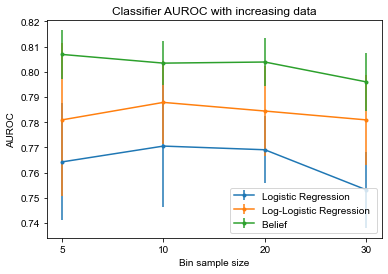

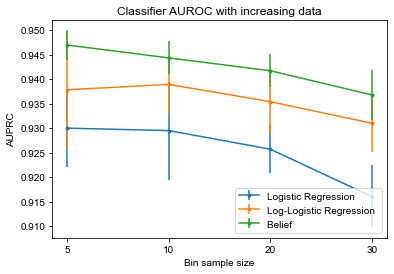

In [159]:
plot_aurocs(ad_rocs, list(range(len(num_low_high))), [t[0] for t in num_low_high],
            'Classifier AUROC with increasing data', 'Bin sample size')
plot_auprcs(ad_prcs, list(range(len(num_low_high))), [t[0] for t in num_low_high],
            'Classifier AUROC with increasing data', 'Bin sample size')


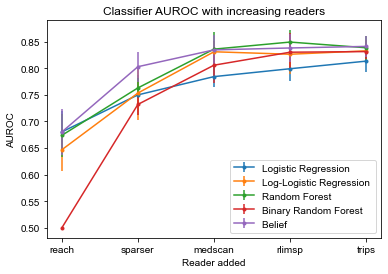

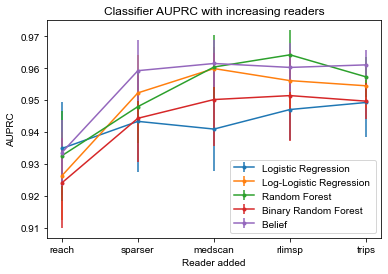

In [156]:
plot_aurocs(clf_aurocs, list(range(len(reader_list))), reader_list,
            'Classifier AUROC with increasing readers', 'Reader added')
plot_auprcs(clf_auprcs, list(range(len(reader_list))), reader_list,
           'Classifier AUPRC with increasing readers', 'Reader added')

In [56]:
reader_subset = reader_list
#reader_subset = ['reach', 'sparser', 'medscan']
train_df = kge_df[reader_subset + ['correct']]

models_ev = {
    'Logistic Regression': LogisticRegression(),
    'Log-Logistic Regression': LogLogisticRegression(),    
    'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
    #'Random Forest': RandomForestClassifier(),
    'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=4),
    #'Belief': BeliefModel(reader_subset),
    #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
    #                           nwalkers=100, burn_steps=100, sample_steps=100)
    'GaussianNB': GaussianNB(),
}

res_ev = eval_models_relation(models_ev, train_df, reader_subset, train_test_split,
                              test_split=0.2, num_folds=10)

100%|██████████| 10/10 [00:00<00:00, 162.14it/s]


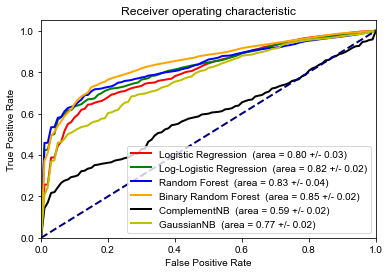

In [57]:
plot_roc(res_ev)

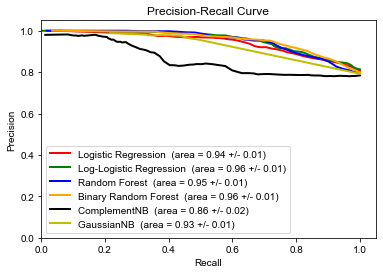

In [58]:
plot_prc(res_ev)

In [198]:
brf = models_ev['Binary Random Forest']
brf.predict_proba(np.array([[0, 10, 0, 0, 0]]))

array([[0.58367613, 0.41632387]])

In [215]:
rf = models_ev['Random Forest']
rf.predict_proba(np.array([[1, 10, 0, 0, 0]]))

array([[0.14988793, 0.85011207]])

In [207]:
llr = models_ev['Log-Logistic Regression']
llr.predict_proba(np.array([[0, 200, 0, 0, 0]]))

array([[0.03367411, 0.96632589]])

In [65]:
bbm = models_ev['BeliefBayes']

In [197]:
example = np.array([[0, 1, 0, 0, 0]])
bbm.predict_proba(example)

array([[0.59493829, 0.40506171]])

In [119]:
df = train_df
# Get exact probability for reach 1, sparser 2
cond_df = df[(df.reach == 1) & (df.sparser == 1) & (df.medscan == 0) & (df.rlimsp == 0) & (df.trips == 0)]
corr_df = cond_df[cond_df.correct == 1]
len(corr_df) / len(cond_df)

0.9

In [126]:
# Get exact probability of p(R1...Rn|c)
df = train_df
corr_df = df[df.correct == 1]
cond_df = corr_df[(corr_df.reach == 1) & (corr_df.sparser == 1) & (corr_df.medscan == 0) & 
                  (corr_df.rlimsp == 0) & (corr_df.trips == 0)]
p_ri_rj_c = len(cond_df) / len(corr_df)
p_ri_rj_c

0.01053864168618267

In [130]:
coeff = bbm.p_correct / bbm.p_ri_rj[tuple(example[0])]
coeff

85.17032710280374

In [131]:
coeff * p_ri_rj_c

0.8975795596314211

In [134]:
prod = coeff
exact = coeff
for i, (reader, val) in enumerate(zip(reader_list, example[0])):
    if val == 0:
        pass
    mf, sampler = bbm.reader_results[reader]
    map_params_dict = mf.get_map_params(sampler)
    params = [map_params_dict[pname] for pname in mf.model.param_names]
    p_c_ri = mf.model.stmt_predictions(params, [val])[0]
    if val == 0:
        p_c_ri = bbm.p_c_r0[reader]
    p_ri = bbm.p_ri[reader][val]
    print(reader)
    print("p_ri", p_ri)
    print("p_c_ri", p_c_ri)
    print()
    prod *= (p_c_ri * p_ri) / bbm.p_correct
    
    corr_df = train_df[train_df.correct == 1]
    ri_df = corr_df[corr_df[reader] == val]
    p_ri_c = len(ri_df) / len(corr_df)
    exact *= p_ri_c
print(prod)
print(exact)

reach
p_ri 0.17305893358278765
p_c_ri 0.7187730205399163

sparser
p_ri 0.13096351730589337
p_c_ri 0.8185742820934272

medscan
p_ri 0.48269410664172124
p_c_ri 0.6724137931034483

rlimsp
p_ri 0.7923292797006548
p_c_ri 0.7756874095513748

trips
p_ri 0.6304957904583723
p_c_ri 0.7337057728119181

0.3264635259833041
0.3488594353515683


  0%|          | 0/10 [00:00<?, ?it/s]

reach (601, 2)


INFO: [2020-10-19 16:51:05] model_fit - Burn in sampling...
INFO: [2020-10-19 16:51:17] model_fit - Main sampling...
INFO: [2020-10-19 16:51:29] model_fit - Done sampling.


sparser (413, 2)


INFO: [2020-10-19 16:51:29] model_fit - Burn in sampling...
INFO: [2020-10-19 16:51:38] model_fit - Main sampling...
INFO: [2020-10-19 16:51:47] model_fit - Done sampling.


medscan (440, 2)


INFO: [2020-10-19 16:51:47] model_fit - Burn in sampling...
INFO: [2020-10-19 16:51:55] model_fit - Main sampling...
INFO: [2020-10-19 16:52:03] model_fit - Done sampling.


rlimsp (181, 2)


INFO: [2020-10-19 16:52:04] model_fit - Burn in sampling...
INFO: [2020-10-19 16:52:07] model_fit - Main sampling...
INFO: [2020-10-19 16:52:11] model_fit - Done sampling.


trips (311, 2)


INFO: [2020-10-19 16:52:11] model_fit - Burn in sampling...
INFO: [2020-10-19 16:52:17] model_fit - Main sampling...
INFO: [2020-10-19 16:52:23] model_fit - Done sampling.
 10%|█         | 1/10 [01:18<11:45, 78.40s/it]

reach (597, 2)


INFO: [2020-10-19 16:52:23] model_fit - Burn in sampling...
INFO: [2020-10-19 16:52:35] model_fit - Main sampling...
INFO: [2020-10-19 16:52:46] model_fit - Done sampling.


sparser (420, 2)


INFO: [2020-10-19 16:52:46] model_fit - Burn in sampling...
INFO: [2020-10-19 16:52:55] model_fit - Main sampling...
INFO: [2020-10-19 16:53:05] model_fit - Done sampling.


medscan (438, 2)


INFO: [2020-10-19 16:53:05] model_fit - Burn in sampling...
INFO: [2020-10-19 16:53:16] model_fit - Main sampling...
INFO: [2020-10-19 16:53:25] model_fit - Done sampling.


rlimsp (185, 2)


INFO: [2020-10-19 16:53:25] model_fit - Burn in sampling...
INFO: [2020-10-19 16:53:29] model_fit - Main sampling...
INFO: [2020-10-19 16:53:33] model_fit - Done sampling.


trips (313, 2)


INFO: [2020-10-19 16:53:33] model_fit - Burn in sampling...
INFO: [2020-10-19 16:53:39] model_fit - Main sampling...
INFO: [2020-10-19 16:53:45] model_fit - Done sampling.
 20%|██        | 2/10 [02:40<10:36, 79.55s/it]

reach (609, 2)


INFO: [2020-10-19 16:53:46] model_fit - Burn in sampling...
INFO: [2020-10-19 16:53:57] model_fit - Main sampling...
INFO: [2020-10-19 16:54:09] model_fit - Done sampling.


sparser (421, 2)


INFO: [2020-10-19 16:54:09] model_fit - Burn in sampling...
INFO: [2020-10-19 16:54:17] model_fit - Main sampling...
INFO: [2020-10-19 16:54:26] model_fit - Done sampling.


medscan (437, 2)


INFO: [2020-10-19 16:54:27] model_fit - Burn in sampling...
INFO: [2020-10-19 16:54:35] model_fit - Main sampling...
INFO: [2020-10-19 16:54:44] model_fit - Done sampling.


rlimsp (185, 2)


INFO: [2020-10-19 16:54:44] model_fit - Burn in sampling...
INFO: [2020-10-19 16:54:48] model_fit - Main sampling...
INFO: [2020-10-19 16:54:52] model_fit - Done sampling.


trips (312, 2)


INFO: [2020-10-19 16:54:52] model_fit - Burn in sampling...
INFO: [2020-10-19 16:54:58] model_fit - Main sampling...
INFO: [2020-10-19 16:55:05] model_fit - Done sampling.
 30%|███       | 3/10 [03:59<09:16, 79.44s/it]

reach (604, 2)


INFO: [2020-10-19 16:55:05] model_fit - Burn in sampling...
INFO: [2020-10-19 16:55:17] model_fit - Main sampling...
INFO: [2020-10-19 16:55:31] model_fit - Done sampling.


sparser (430, 2)


INFO: [2020-10-19 16:55:31] model_fit - Burn in sampling...
INFO: [2020-10-19 16:55:40] model_fit - Main sampling...
INFO: [2020-10-19 16:55:49] model_fit - Done sampling.


medscan (445, 2)


INFO: [2020-10-19 16:55:49] model_fit - Burn in sampling...
INFO: [2020-10-19 16:55:59] model_fit - Main sampling...
INFO: [2020-10-19 16:56:07] model_fit - Done sampling.


rlimsp (177, 2)


INFO: [2020-10-19 16:56:08] model_fit - Burn in sampling...
INFO: [2020-10-19 16:56:11] model_fit - Main sampling...
INFO: [2020-10-19 16:56:15] model_fit - Done sampling.


trips (320, 2)


INFO: [2020-10-19 16:56:15] model_fit - Burn in sampling...
INFO: [2020-10-19 16:56:21] model_fit - Main sampling...
INFO: [2020-10-19 16:56:27] model_fit - Done sampling.
 40%|████      | 4/10 [05:22<08:02, 80.41s/it]

reach (604, 2)


INFO: [2020-10-19 16:56:27] model_fit - Burn in sampling...
INFO: [2020-10-19 16:56:39] model_fit - Main sampling...
INFO: [2020-10-19 16:56:50] model_fit - Done sampling.


sparser (428, 2)


INFO: [2020-10-19 16:56:50] model_fit - Burn in sampling...
INFO: [2020-10-19 16:56:59] model_fit - Main sampling...
INFO: [2020-10-19 16:57:07] model_fit - Done sampling.


medscan (431, 2)


INFO: [2020-10-19 16:57:07] model_fit - Burn in sampling...
INFO: [2020-10-19 16:57:15] model_fit - Main sampling...
INFO: [2020-10-19 16:57:23] model_fit - Done sampling.


rlimsp (187, 2)


INFO: [2020-10-19 16:57:23] model_fit - Burn in sampling...
INFO: [2020-10-19 16:57:27] model_fit - Main sampling...
INFO: [2020-10-19 16:57:30] model_fit - Done sampling.


trips (319, 2)


INFO: [2020-10-19 16:57:30] model_fit - Burn in sampling...
INFO: [2020-10-19 16:57:37] model_fit - Main sampling...
INFO: [2020-10-19 16:57:43] model_fit - Done sampling.
 50%|█████     | 5/10 [06:38<06:35, 79.15s/it]

reach (602, 2)


INFO: [2020-10-19 16:57:44] model_fit - Burn in sampling...
INFO: [2020-10-19 16:57:56] model_fit - Main sampling...
INFO: [2020-10-19 16:58:07] model_fit - Done sampling.


sparser (436, 2)


INFO: [2020-10-19 16:58:07] model_fit - Burn in sampling...
INFO: [2020-10-19 16:58:16] model_fit - Main sampling...
INFO: [2020-10-19 16:58:25] model_fit - Done sampling.


medscan (433, 2)


INFO: [2020-10-19 16:58:25] model_fit - Burn in sampling...
INFO: [2020-10-19 16:58:34] model_fit - Main sampling...
INFO: [2020-10-19 16:58:42] model_fit - Done sampling.


rlimsp (175, 2)


INFO: [2020-10-19 16:58:42] model_fit - Burn in sampling...
INFO: [2020-10-19 16:58:46] model_fit - Main sampling...
INFO: [2020-10-19 16:58:50] model_fit - Done sampling.


trips (323, 2)


INFO: [2020-10-19 16:58:50] model_fit - Burn in sampling...
INFO: [2020-10-19 16:58:57] model_fit - Main sampling...
INFO: [2020-10-19 16:59:03] model_fit - Done sampling.
 60%|██████    | 6/10 [07:58<05:17, 79.38s/it]

reach (599, 2)


INFO: [2020-10-19 16:59:04] model_fit - Burn in sampling...
INFO: [2020-10-19 16:59:15] model_fit - Main sampling...
INFO: [2020-10-19 16:59:27] model_fit - Done sampling.


sparser (424, 2)


INFO: [2020-10-19 16:59:27] model_fit - Burn in sampling...
INFO: [2020-10-19 16:59:36] model_fit - Main sampling...
INFO: [2020-10-19 16:59:45] model_fit - Done sampling.


medscan (431, 2)


INFO: [2020-10-19 16:59:45] model_fit - Burn in sampling...
INFO: [2020-10-19 16:59:53] model_fit - Main sampling...
INFO: [2020-10-19 17:00:02] model_fit - Done sampling.


rlimsp (181, 2)


INFO: [2020-10-19 17:00:02] model_fit - Burn in sampling...
INFO: [2020-10-19 17:00:06] model_fit - Main sampling...
INFO: [2020-10-19 17:00:10] model_fit - Done sampling.


trips (318, 2)


INFO: [2020-10-19 17:00:10] model_fit - Burn in sampling...
INFO: [2020-10-19 17:00:16] model_fit - Main sampling...
INFO: [2020-10-19 17:00:23] model_fit - Done sampling.
 70%|███████   | 7/10 [09:17<03:58, 79.35s/it]

reach (601, 2)


INFO: [2020-10-19 17:00:23] model_fit - Burn in sampling...
INFO: [2020-10-19 17:00:34] model_fit - Main sampling...
INFO: [2020-10-19 17:00:46] model_fit - Done sampling.


sparser (425, 2)


INFO: [2020-10-19 17:00:46] model_fit - Burn in sampling...
INFO: [2020-10-19 17:00:54] model_fit - Main sampling...
INFO: [2020-10-19 17:01:03] model_fit - Done sampling.


medscan (448, 2)


INFO: [2020-10-19 17:01:03] model_fit - Burn in sampling...
INFO: [2020-10-19 17:01:12] model_fit - Main sampling...
INFO: [2020-10-19 17:01:21] model_fit - Done sampling.


rlimsp (180, 2)


INFO: [2020-10-19 17:01:21] model_fit - Burn in sampling...
INFO: [2020-10-19 17:01:25] model_fit - Main sampling...
INFO: [2020-10-19 17:01:29] model_fit - Done sampling.


trips (316, 2)


INFO: [2020-10-19 17:01:29] model_fit - Burn in sampling...
INFO: [2020-10-19 17:01:36] model_fit - Main sampling...
INFO: [2020-10-19 17:01:42] model_fit - Done sampling.
 80%|████████  | 8/10 [10:37<02:38, 79.41s/it]

reach (612, 2)


INFO: [2020-10-19 17:01:42] model_fit - Burn in sampling...
INFO: [2020-10-19 17:01:58] model_fit - Main sampling...
INFO: [2020-10-19 17:02:11] model_fit - Done sampling.


sparser (434, 2)


INFO: [2020-10-19 17:02:11] model_fit - Burn in sampling...
INFO: [2020-10-19 17:02:20] model_fit - Main sampling...
INFO: [2020-10-19 17:02:30] model_fit - Done sampling.


medscan (445, 2)


INFO: [2020-10-19 17:02:30] model_fit - Burn in sampling...
INFO: [2020-10-19 17:02:39] model_fit - Main sampling...
INFO: [2020-10-19 17:02:48] model_fit - Done sampling.


rlimsp (184, 2)


INFO: [2020-10-19 17:02:49] model_fit - Burn in sampling...
INFO: [2020-10-19 17:02:53] model_fit - Main sampling...
INFO: [2020-10-19 17:02:57] model_fit - Done sampling.


trips (325, 2)


INFO: [2020-10-19 17:02:57] model_fit - Burn in sampling...
INFO: [2020-10-19 17:03:04] model_fit - Main sampling...
INFO: [2020-10-19 17:03:10] model_fit - Done sampling.
 90%|█████████ | 9/10 [12:05<01:21, 81.95s/it]

reach (611, 2)


INFO: [2020-10-19 17:03:10] model_fit - Burn in sampling...
INFO: [2020-10-19 17:03:23] model_fit - Main sampling...
INFO: [2020-10-19 17:03:35] model_fit - Done sampling.


sparser (420, 2)


INFO: [2020-10-19 17:03:36] model_fit - Burn in sampling...
INFO: [2020-10-19 17:03:44] model_fit - Main sampling...
INFO: [2020-10-19 17:03:53] model_fit - Done sampling.


medscan (446, 2)


INFO: [2020-10-19 17:03:54] model_fit - Burn in sampling...
INFO: [2020-10-19 17:04:03] model_fit - Main sampling...
INFO: [2020-10-19 17:04:12] model_fit - Done sampling.


rlimsp (174, 2)


INFO: [2020-10-19 17:04:12] model_fit - Burn in sampling...
INFO: [2020-10-19 17:04:16] model_fit - Main sampling...
INFO: [2020-10-19 17:04:20] model_fit - Done sampling.


trips (321, 2)


INFO: [2020-10-19 17:04:20] model_fit - Burn in sampling...
INFO: [2020-10-19 17:04:27] model_fit - Main sampling...
INFO: [2020-10-19 17:04:33] model_fit - Done sampling.
100%|██████████| 10/10 [13:28<00:00, 80.83s/it]


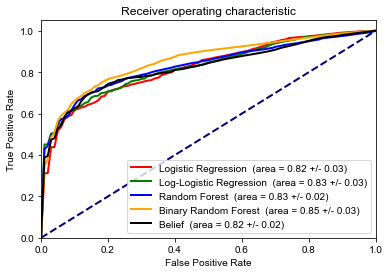

In [49]:
reader_subset = ['reach', 'medscan']
reader_subset = reader_list

models_ev = {
    'Logistic Regression': LogisticRegression(),
    'Log-Logistic Regression': LogLogisticRegression(),    
    'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
    #'Random Forest': RandomForestClassifier(),
    'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=4),
    #'Belief': BeliefModel(reader_subset)
}

train_df = kge_df[reader_subset + ['correct']]
res_ev = eval_models_relation(models_ev, train_df, reader_subset, train_test_split,
                              test_split=0.2, num_folds=10)

plot_roc(res_ev)

  0%|          | 0/10 [00:00<?, ?it/s]

reach (37, 2)


INFO: [2020-10-08 11:59:14] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:15] model_fit - Main sampling...
INFO: [2020-10-08 11:59:16] model_fit - Done sampling.


sparser (35, 2)


INFO: [2020-10-08 11:59:16] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:17] model_fit - Main sampling...
INFO: [2020-10-08 11:59:18] model_fit - Done sampling.


medscan (36, 2)


INFO: [2020-10-08 11:59:19] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:20] model_fit - Main sampling...
INFO: [2020-10-08 11:59:21] model_fit - Done sampling.


rlimsp (21, 2)


INFO: [2020-10-08 11:59:21] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:22] model_fit - Main sampling...
INFO: [2020-10-08 11:59:23] model_fit - Done sampling.


trips (32, 2)


INFO: [2020-10-08 11:59:23] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:24] model_fit - Main sampling...
INFO: [2020-10-08 11:59:25] model_fit - Done sampling.
 10%|█         | 1/10 [00:11<01:45, 11.71s/it]

reach (42, 2)


INFO: [2020-10-08 11:59:25] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:26] model_fit - Main sampling...
INFO: [2020-10-08 11:59:28] model_fit - Done sampling.


sparser (38, 2)


INFO: [2020-10-08 11:59:28] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:29] model_fit - Main sampling...
INFO: [2020-10-08 11:59:30] model_fit - Done sampling.


medscan (31, 2)


INFO: [2020-10-08 11:59:30] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:31] model_fit - Main sampling...
INFO: [2020-10-08 11:59:32] model_fit - Done sampling.


rlimsp (17, 2)


INFO: [2020-10-08 11:59:32] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:33] model_fit - Main sampling...
INFO: [2020-10-08 11:59:34] model_fit - Done sampling.


trips (27, 2)


INFO: [2020-10-08 11:59:34] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:35] model_fit - Main sampling...
INFO: [2020-10-08 11:59:36] model_fit - Done sampling.
 20%|██        | 2/10 [00:22<01:30, 11.36s/it]

reach (37, 2)


INFO: [2020-10-08 11:59:36] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:37] model_fit - Main sampling...
INFO: [2020-10-08 11:59:38] model_fit - Done sampling.


sparser (30, 2)


INFO: [2020-10-08 11:59:38] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:39] model_fit - Main sampling...
INFO: [2020-10-08 11:59:40] model_fit - Done sampling.


medscan (27, 2)


INFO: [2020-10-08 11:59:40] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:41] model_fit - Main sampling...
INFO: [2020-10-08 11:59:42] model_fit - Done sampling.


rlimsp (14, 2)


INFO: [2020-10-08 11:59:42] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:43] model_fit - Main sampling...
INFO: [2020-10-08 11:59:44] model_fit - Done sampling.


trips (23, 2)


INFO: [2020-10-08 11:59:44] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:45] model_fit - Main sampling...
INFO: [2020-10-08 11:59:46] model_fit - Done sampling.
 30%|███       | 3/10 [00:32<01:16, 10.90s/it]

reach (40, 2)


INFO: [2020-10-08 11:59:46] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:47] model_fit - Main sampling...
INFO: [2020-10-08 11:59:48] model_fit - Done sampling.


sparser (38, 2)


INFO: [2020-10-08 11:59:48] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:49] model_fit - Main sampling...
INFO: [2020-10-08 11:59:50] model_fit - Done sampling.


medscan (33, 2)


INFO: [2020-10-08 11:59:50] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:51] model_fit - Main sampling...
INFO: [2020-10-08 11:59:52] model_fit - Done sampling.


rlimsp (14, 2)


INFO: [2020-10-08 11:59:52] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:53] model_fit - Main sampling...
INFO: [2020-10-08 11:59:54] model_fit - Done sampling.


trips (29, 2)


INFO: [2020-10-08 11:59:54] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:55] model_fit - Main sampling...
INFO: [2020-10-08 11:59:56] model_fit - Done sampling.
 40%|████      | 4/10 [00:42<01:04, 10.67s/it]

reach (38, 2)


INFO: [2020-10-08 11:59:56] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:57] model_fit - Main sampling...
INFO: [2020-10-08 11:59:58] model_fit - Done sampling.


sparser (35, 2)


INFO: [2020-10-08 11:59:58] model_fit - Burn in sampling...
INFO: [2020-10-08 11:59:59] model_fit - Main sampling...
INFO: [2020-10-08 12:00:00] model_fit - Done sampling.


medscan (33, 2)


INFO: [2020-10-08 12:00:00] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:01] model_fit - Main sampling...
INFO: [2020-10-08 12:00:02] model_fit - Done sampling.


rlimsp (15, 2)


INFO: [2020-10-08 12:00:02] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:03] model_fit - Main sampling...
INFO: [2020-10-08 12:00:04] model_fit - Done sampling.


trips (28, 2)


INFO: [2020-10-08 12:00:04] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:05] model_fit - Main sampling...
INFO: [2020-10-08 12:00:05] model_fit - Done sampling.
 50%|█████     | 5/10 [00:51<00:51, 10.40s/it]

reach (37, 2)


INFO: [2020-10-08 12:00:06] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:07] model_fit - Main sampling...
INFO: [2020-10-08 12:00:08] model_fit - Done sampling.


sparser (30, 2)


INFO: [2020-10-08 12:00:08] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:09] model_fit - Main sampling...
INFO: [2020-10-08 12:00:10] model_fit - Done sampling.


medscan (32, 2)


INFO: [2020-10-08 12:00:10] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:11] model_fit - Main sampling...
INFO: [2020-10-08 12:00:11] model_fit - Done sampling.


rlimsp (13, 2)


INFO: [2020-10-08 12:00:12] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:12] model_fit - Main sampling...
INFO: [2020-10-08 12:00:13] model_fit - Done sampling.


trips (29, 2)


INFO: [2020-10-08 12:00:13] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:14] model_fit - Main sampling...
INFO: [2020-10-08 12:00:15] model_fit - Done sampling.
 60%|██████    | 6/10 [01:01<00:40, 10.08s/it]

reach (34, 2)


INFO: [2020-10-08 12:00:15] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:16] model_fit - Main sampling...
INFO: [2020-10-08 12:00:17] model_fit - Done sampling.


sparser (32, 2)


INFO: [2020-10-08 12:00:17] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:18] model_fit - Main sampling...
INFO: [2020-10-08 12:00:19] model_fit - Done sampling.


medscan (34, 2)


INFO: [2020-10-08 12:00:19] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:20] model_fit - Main sampling...
INFO: [2020-10-08 12:00:21] model_fit - Done sampling.


rlimsp (14, 2)


INFO: [2020-10-08 12:00:21] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:22] model_fit - Main sampling...
INFO: [2020-10-08 12:00:22] model_fit - Done sampling.


trips (26, 2)


INFO: [2020-10-08 12:00:22] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:23] model_fit - Main sampling...
INFO: [2020-10-08 12:00:24] model_fit - Done sampling.
 70%|███████   | 7/10 [01:10<00:29,  9.88s/it]

reach (42, 2)


INFO: [2020-10-08 12:00:24] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:25] model_fit - Main sampling...
INFO: [2020-10-08 12:00:26] model_fit - Done sampling.


sparser (38, 2)


INFO: [2020-10-08 12:00:27] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:28] model_fit - Main sampling...
INFO: [2020-10-08 12:00:29] model_fit - Done sampling.


medscan (33, 2)


INFO: [2020-10-08 12:00:29] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:30] model_fit - Main sampling...
INFO: [2020-10-08 12:00:31] model_fit - Done sampling.


rlimsp (21, 2)


INFO: [2020-10-08 12:00:31] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:32] model_fit - Main sampling...
INFO: [2020-10-08 12:00:32] model_fit - Done sampling.


trips (30, 2)


INFO: [2020-10-08 12:00:32] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:33] model_fit - Main sampling...
INFO: [2020-10-08 12:00:34] model_fit - Done sampling.
 80%|████████  | 8/10 [01:20<00:19,  9.90s/it]

reach (38, 2)


INFO: [2020-10-08 12:00:34] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:35] model_fit - Main sampling...
INFO: [2020-10-08 12:00:36] model_fit - Done sampling.


sparser (35, 2)


INFO: [2020-10-08 12:00:36] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:37] model_fit - Main sampling...
INFO: [2020-10-08 12:00:38] model_fit - Done sampling.


medscan (31, 2)


INFO: [2020-10-08 12:00:38] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:39] model_fit - Main sampling...
INFO: [2020-10-08 12:00:40] model_fit - Done sampling.


rlimsp (17, 2)


INFO: [2020-10-08 12:00:41] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:41] model_fit - Main sampling...
INFO: [2020-10-08 12:00:42] model_fit - Done sampling.


trips (28, 2)


INFO: [2020-10-08 12:00:42] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:43] model_fit - Main sampling...
INFO: [2020-10-08 12:00:44] model_fit - Done sampling.
 90%|█████████ | 9/10 [01:30<00:10, 10.00s/it]

reach (38, 2)


INFO: [2020-10-08 12:00:45] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:46] model_fit - Main sampling...
INFO: [2020-10-08 12:00:47] model_fit - Done sampling.


sparser (34, 2)


INFO: [2020-10-08 12:00:47] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:48] model_fit - Main sampling...
INFO: [2020-10-08 12:00:49] model_fit - Done sampling.


medscan (34, 2)


INFO: [2020-10-08 12:00:49] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:50] model_fit - Main sampling...
INFO: [2020-10-08 12:00:51] model_fit - Done sampling.


rlimsp (14, 2)


INFO: [2020-10-08 12:00:51] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:51] model_fit - Main sampling...
INFO: [2020-10-08 12:00:52] model_fit - Done sampling.


trips (25, 2)


INFO: [2020-10-08 12:00:52] model_fit - Burn in sampling...
INFO: [2020-10-08 12:00:53] model_fit - Main sampling...
INFO: [2020-10-08 12:00:54] model_fit - Done sampling.
100%|██████████| 10/10 [01:40<00:00, 10.04s/it]


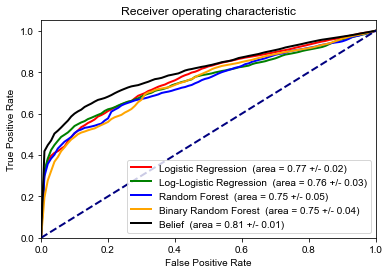

In [131]:
reader_subset = reader_list

def split_closure(x_data, y_data, test_size):
    return split_by_ev_ct(x_data, y_data, reader_subset, low_ub=1, num_low=5,
                          high_lb=8, num_high=5, test_size=test_size)

models_ev = {
    'Logistic Regression': LogisticRegression(),
    'Log-Logistic Regression': LogLogisticRegression(),    
    'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
    #'Random Forest': RandomForestClassifier(),
    'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=4),
    'Belief': BeliefModel(reader_subset)
}

train_df = kge_df[reader_subset + ['correct']]
res_ev = eval_models_relation(models_ev, train_df, reader_subset, split_closure, num_folds=10)

plot_roc(res_ev)

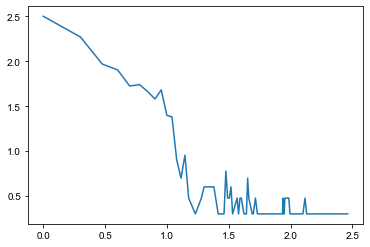

In [149]:
#plt.figure()
#x_vals = kge_df[kge_df['reach'] > 0]['reach'].values
#plt.hist(x_vals)
df = kge_df.copy()
x_vals = []
y_vals = []
for ct, ct_df in df.groupby('reach'):
    x_vals.append(ct)
    y_vals.append(len(ct_df))
x_vals = np.array(x_vals)
y_vals = np.array(y_vals)
plt.figure()
plt.plot(np.log10(x_vals + 1), np.log10(y_vals + 1))

### Properties of belief scores under different assumptions

To illustrate the properties of belief scores under different assumptions about reader performance and dependence, we generated simulated data using the following approach. We imagine a space of $(relation,sentence)$ combinations defined for a defined text corpus and set of relation types, and over this space, with overall size $n$, we have a baseline probability, prior to the consideration of any reading systems, of a particular $(relation_i,sentence_j)$ being correct, denoted $p(corr)$. Then, for each reader, we define the recall and false discovery rate (FDR) as follows:

$$R_i^{re} = p(R_i=1|corr=1) = \frac{TP}{FN + TP}$$

$$R_i^{fdr} = p(corr=1|R_i=1) = \frac{FP}{TP + FP}$$

where TP, TN, FP, and FN denote the true positives, true negatives, false positives, and false negatives, respectively. We note that $p(corr) = \frac{TP + FN}{n}$. Then given the four parameters $n$, $p(corr)$, $R_i^{re}$, and $R_i^{fdr}$, we calculate TP, TN, FP, and FN for each reader $R_i$ as follows:

$$TP_i = R_i^{re} \cdot p(corr) \cdot n$$

$$FP_i = \frac{TP_i \cdot R_i^{fdr}}{1 - R_i^{fdr}}$$

$$FN_i = p(corr) \cdot n - TP_i$$

$$TN_i = p(corr) \cdot n - TP_i - FP_i - TN_i$$


Imagine subsets of these statements that have a higher likelihood of extraction by both readers, e.g., the high frequency ones.

Imagine a base number, e.g. of sentences. R1 generates a correct or incorrect. R2 generates a correct or incorrect.

In [ ]:
# Simulator of reader data (incomplete)
class Simulator(object):
    def __init__(self, p_correct, base_n, reader_params):
        """Simulation distribution of reader output and correctness.
        
        Parameters
        ----------
        p_correct : float
            Baseline probability of correctness for a given (relation, sentence).
        base_n : int
            The size of the overall (relation, sentence) event space.
        reader_params: dict
            Dictionary of reader precision and recall values. Keys denote
            reader names, values are tuples of floats (fdr, recall).
        """
        self.p_correct = p_correct
        self.base_n = base_n
        self.reader_params = reader_params 
        self.reader_counts = {}
    
    def simulate(self):
        event_space = np.random.choice([0, 1], size=self.base_n,
                                       p=[1-self.p_correct, self.p_correct])
        self.num_correct = event_space.sum()
        df = pd.DataFrame(event_space, columns=['correct'])
        for r_name, (fdr, rec) in self.reader_params.items():
            tp = rec * self.num_correct
            fp = (fdr * tp) / (1 - fdr)
            #fp = fp_rate * (self.base_n - self.num_correct)
            fn = self.num_correct - tp
            tn = self.base_n - tp - fp - fn
            #print("Num correct", self.num_correct)
            #print(tp, fp, fn, tn, self.base_n)
            #print("Total", tp+tn+fp+fn)
            self.reader_counts[r_name] = {'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}
            # Get a vector of R and ~R of length num_correct
            corr_arr = np.random.choice([0, 1], size=self.num_correct,
                                        p=(1-rec, rec))
            inc_arr = np.random.choice([0, 1], size=self.base_n - self.num_correct,
                                       p=(1 - fp/(fp+tn), fp/(fp+tn)))
            # Assign to the subspace of correct statements
            df.loc[df['correct']==1, r_name] = corr_arr            
            df.loc[df['correct']==0, r_name] = inc_arr
        df = df.astype('int')
        reader_names = list(self.reader_params.keys())
        filt_df = df[df[reader_names].any(1)]
        return filt_df, df

    def summarize(self, df):
        r_names = [col for col in df.columns if col != 'correct']
        p_corr = prob([('correct', 1)], df=df)
        abs_p_corr = self.p_correct
        reader_mat = []
        cond_probs = [f'p(ri=1|{r}=1)' for r in r_names]
        index = ['Abs Recall', 'Abs FDR', 'Precision', 'Recall', 'FDR',
                 'Abs p(corr)', 'p(corr)', 'p(ri)'] + cond_probs
        for reader_i in r_names:
            rec_param = self.reader_params[reader_i][1]
            fdr_param = self.reader_params[reader_i][0]
            prec = prob([('correct', 1)], [(reader_i, 1)], df)
            recall = prob([(reader_i, 1)], [('correct', 1)], df)
            fdr = prob([('correct', 0)], [(reader_i, 1)], df)
            p_r = prob([(reader_i, 1)], df=df)
            reader_data = [rec_param, fdr_param, prec, recall, fdr, abs_p_corr, p_corr, p_r]
            for reader_j in r_names:
                cond_prob = prob([(reader_i, 1)], [(reader_j, 1)], df)
                reader_data.append(cond_prob)
            reader_mat.append(reader_data)
        # Transpose the list of lists
        reader_mat = list(map(list, zip(*reader_mat)))
        return pd.DataFrame(reader_mat, index=index, columns=r_names)
    
    def joint_probs(self, df):
        r_abbrevs = {r: r for r in df.columns}
        col_list = [r for r in df.columns]
        freq_dict, _ = get_reader_freq_from_curation(df, col_list, r_abbrevs)
        return make_df(freq_dict, 'Readers', 'Exact')
    
    def corr_probs(self, df):
        r_names = [col for col in df.columns if col != 'correct']
        cp_dict = {} # Conditional probability dictionary
        # Get precision estimates for each reader
        err_dict = {}
        belief_dict = {}
        for reader in r_names:
            err_dict[reader] = prob([('correct', 0)], [(reader, 1)], df)
        for r_obs_list in itertools.product([0, 1], repeat=len(r_names)):
            c_prob = []
            label = []
            err_prob = 1
            for i, r_name in enumerate(r_names):
                if r_obs_list[i]:
                    label.append(r_name)
                    c_prob.append((r_name, 1))
                    err_prob *= err_dict[r_name]
                else:
                    label.append('_')
                    c_prob.append((r_name, 0))
            cp_dict[tuple(label)] = prob([('correct', 1)], c_prob, df)
            belief_dict[tuple(label)] = 1 - err_prob
        df_prob = make_df(cp_dict, 'Readers', 'Probability')
        df_belief = make_df(belief_dict, 'Readers', 'Belief')
        return df_prob.join(df_belief)

def cond_probs(df):
    r_names = [col for col in df.columns if col != 'correct']
    reader_mat = []
    cond_probs = [f'p(ri=1|{r}=1)' for r in r_names]
    index = ['p(ri)'] + cond_probs

    for reader_i in r_names:
        p_r = prob([(reader_i, 1)], df=df)
        reader_data = [p_r]
        for reader_j in r_names:
            cond_prob = prob([(reader_i, 1)], [(reader_j, 1)], df)
            reader_data.append(cond_prob)
        reader_mat.append(reader_data)
    reader_mat = list(map(list, zip(*reader_mat)))
    return pd.DataFrame(reader_mat, index=index, columns=r_names)
 

In [ ]:
# Problem with this approach--high false positive rate allows readers
# to be correlated by both returning 1 for a high proportion of negatives
sim = Simulator(0.2, 1000000, {'r1': (0.25, 0.8),
                               'r2': (0.4, 0.8),
                               'r3': (0.1, 0.8),
                             })
df, full_df = sim.simulate()

When the space of incorrect statements is very large, this means that the chance of overlap between readers in incorrect statements is small. However, the probability of an individual reader producing an error

In [ ]:
sim_reader_freq, _ = get_reader_freq_from_curation(df, ['r1', 'r2', 'r3'], )
make_df(sim_reader_freq, 'Readers', 'Frequency')

In [ ]:
sim.summarize(df)

In [ ]:
sim.joint_probs(df)

In [ ]:
cps = sim.corr_probs(df)
cps

In [ ]:
cps.corr('spearman')

If absolute recall of both is low, then this means that each gets a small subset of the total possible statements. When aggregated and the 0s are filtered out, this means that there is very little overlap between the readers, the sets are non-complementaray, and they are anti-correlated. If absolute recall is basically 1, and FP rate is 0, this means that the two readers basically return the same sets of statements--so how can they be anticorrelated??? If the readers are perfect, in the case of two readers, the correlation is actually 0 (!) because there is so little covariance.

Some observations. First, if recall and fdr are equal and the same for both readers, having evidence from both readers doesn't increase p(correct), because adding a second reader adds somewhat to the coverage of the correct statements but also adds an equal number of false positives.

Recall determines the number of TPs. If FDR = 0.5, it means that FP / TP + FP = 0.5, i.e., FP = TP.

# Orphans

In [ ]:
# Functions for generating datasets assuming different assumptions.
def all_ind(r_names, size, p_readers, p_correct):
    all_cols = ['correct'] + r_names
    all_p = [p_correct] + p_readers
    arrs = []
    for varn, p in zip(r_names, p_readers):
        arr = np.random.choice([0, 1], size=size, p=[1-p, p])
        arrs.append(arr)
    mat = np.vstack(arrs).T
    df_reader = pd.DataFrame(mat, columns=r_names)
    # Filter out the rows with all 0s from readers
    reader_arr = df_reader[df_reader.any(1)].values
    # Construct the column for correctness
    corr_arr = np.random.choice([0, 1], size=(reader_arr.shape[0], 1),
                                p=[1 - p_correct, p_correct])
    full_arr = np.hstack([corr_arr, reader_arr])
    df = pd.DataFrame(full_arr, columns=all_cols)
    return df


In [ ]:
def mutual_info(col1, col2, df):
    """Mutual information between two binary variables in df."""
    total = 0
    for c1_val, c2_val in itertools.product([0, 1], repeat=2):
        pxy = prob([(col1, c1_val), (col2, c2_val)], df=df)
        denom = prob([(col1, c1_val)], df=df) * prob([(col2, c2_val)], df=df)
        if pxy == 0 or denom == 0:
            continue
        print(c1_val, c2_val, pxy, denom)
        total += pxy * np.log2(pxy/denom)
    return total

In [ ]:
#with open('belief_fpr_tpr_auc.pkl', 'rb') as f:
#    bel_fpr, bel_tpr, bel_roc_auc = pickle.load(f)


In [ ]:
#with open('belief_prec_rec_thresh_auc.pkl', 'rb') as f:
#    bel_prec, bel_rec, bel_thresh, bel_pr_auc = pickle.load(f)


In [ ]:
"""
pr_results = {}
for clf_name, clf_result in clf_results.items():
    precision, recall, thresholds = precision_recall_curve(y_test, clf_result['y_probs'][:, 1])
    pr_auc = metrics.auc(recall, precision)
    pr_results[clf_name] = {'precision': precision, 'recall': recall,
                            'thresholds': thresholds, 'pr_auc': pr_auc}
"""

"""
plt.figure()
plt.plot(bel_thresh, bel_prec[: -1], color=colors[0],
             linestyle='-', label="Orig. Belief Precision (area = %0.2f)" % bel_pr_auc)
plt.plot(bel_thresh, bel_rec[: -1], color=colors[0],
             linestyle='--', label="Orig. Belief Recall")
""" 

### Logistic Regression

In [ ]:
logisticRegr.coef_

In [ ]:
sorted(list(zip(x_df.columns, logisticRegr.coef_[0])), key=lambda x: x[1], reverse=True)

### Examining probabilities and assumptions

In [ ]:
#rs_only_df = kge_df[(kge_df[r1] > 0) | (kge_df[r2] > 0)]
#rs_only_df = kge_df[(kge_df[r1] > 0) | (kge_df[r2] > 0) | (kge_df[r3] > 0)]
# Readers are same / 100% dependent
#rs_only_df[r2] = kge_df[r1]
# Readers are independent
#rs_only_df[r2] = rs_only_df[r2].sample(frac=1).values
#rs_only_df = kge_df

# Test for conditional independence--is R1 independent of R2 given corr?
print(f"p({reader1} | {reader2}, corr)", prob([(r1, 1)], [(r2, 1), ('correct', 1)]))
print(f"p({reader1} | corr)", prob([(r1, 1)], [('correct', 1)]))
print()

# Are r1 and r2 independent?
print(f"p({reader1} and {reader2})", prob([(r1, 1), (r2, 1)]))
print(f"p({reader1}) * p({reader2})", prob([(r1, 1)]) * prob([(r2, 1)]))
print()

print(f"Ground truth: p(corr, {reader1}, {reader2})", prob([('correct', 1), (r1, 1), (r2, 1)]))
print(f"Ground truth: p({reader1}, {reader2})", prob([(r1, 1), (r2, 1)]))
print(f"Ground truth: p(corr | {reader1}, {reader2})", prob([('correct', 1)], [(r1, 1), (r2, 1)]))
print(f"Assume corr CI of {reader1} given {reader2} = p(corr | {reader2})",
      prob([('correct', 1)], [(reader2, 1)]))


In [ ]:
# Both readers > 0
df = bin_df
print(r1, "only", len(df[(df[r1] > 0) & (df[r2] == 0)]))
print(r2, "only", len(df[(df[r2] > 0) & (df[r1] == 0)]))
print(r1, "and", r2, len(df[(df[r2] > 0) & (df[r1] > 0)]))
print("total", len(df))

In [ ]:
# 1. The joint event
prob([('correct', 1), (r1, 1), (r2, 1)])

In [ ]:
# 2. By chain rule (exact vs above)
prob([(r1, 1)]) * prob([('correct', 1)], [(r1, 1)]) * prob([(r2, 1)], [('correct', 1), (r1, 1)])

In [ ]:
# 3. What we want to know: p(c|r,s) (exact)
prob([('correct', 1)], [(r1, 1), (r2, 1)])

In [ ]:
# 4. What we want to know, by defn of cond prob vs. above (exact)
prob([('correct', 1), (r1, 1), (r2, 1)]) / prob([(r1, 1), (r2, 1)]) #

In [ ]:
# 5 Applying chain rule (combining 2 and 4)
((prob([(r1, 1)]) * prob([('correct', 1)], [(r1, 1)]) * prob([(r2, 1)], [('correct', 1), (r1, 1)])) / 
     prob([(r1, 1), (r2, 1)]))

In [ ]:
# 6. Applying Bayes rule for p(r2|c,r1)
((prob([(r1, 1)]) * prob([('correct', 1)], [(r1, 1)]) * prob([('correct', 1), (r1, 1)], [(r2, 1)]) * prob([(r2, 1)])) / 
     (prob([(r1, 1), (r2, 1)])*prob([('correct', 1)], [(r1, 1)])*prob([(r1, 1)])))

In [ ]:
# 7. Cancel terms * (Exact)
# p(c,r1|r2) * p(r2)
# ------------------
#      p(r1,r2)
exact = (prob([('correct', 1), (r1, 1)], [(r2, 1)]) * prob([(r2, 1)])) / (prob([(r1, 1), (r2, 1)]))
print("Exact:", exact)

# 8. Complete identity/correlation
redundant = prob([('correct', 1)], [(r2, 1)])
print("Redundant:", redundant)

# 9. Complete independence
indep = (prob([('correct', 1)], [(r1, 1)]) * prob([('correct', 1)], [(r2, 1)])) / prob([('correct', 1)])
print("Independent", indep)

# 10. Like coin flips
coins = 1 - (1 - prob([('correct', 1)], [(r1, 1)])) * (1 - prob([('correct', 1)], [(r2, 1)])) 
print("Joint belief:", coins)

# 8. Substituting approximation: p(c,r1|r2) = p(c|r2)*p(r1|r2)
# p(c|r2) * p(r1|r2) * p(r2)
# --------------------------
#      p(r1,r2)
#(prob(['correct'], [r2]) * prob([r1], [r2]) * prob([r2])) / (prob([r1, r2]))

# Full independence:
# p(c|r2) * p(r1) * p(r2)
# -------------------------- = p(c|r2)
#      p(r1) * p(r2)

# Full dependence:
# p(c|r2) * 1 * p(r2)
# --------------------------
#      p(r1,r2)

#((prob([r1]) * prob(['correct'], [r1]) * prob([r1], [r2]) * prob([r2])) / 
#     (prob([r1, r2])*prob(['correct'], [r1])*prob([r1])))

In [ ]:
# An expression that we need.
# If only one reader, all rows will have at least one evidence from that reader, whether correct or not
prob([(r1, 1), (r2, 1)], [('correct', 1)])

In [ ]:
# Approximation of above - if readers are the same, this should be quite wrong; if independent, quite right
prob([(r1, 1)], [('correct', 1)]) * prob([(r2, 1)], [('correct', 1)])

In [ ]:
prob([(r1, 1)], [('correct', 1)])

In [ ]:
# Bayes rule vs p(r1,r2|c) - exact
(prob([('correct', 1)], [(r1, 1), (r2, 1)]) * prob([(r1, 1), (r2, 1)])) / prob([('correct', 1)])

In [ ]:
# Rearrange from above - exact
(prob([(r1, 1), (r2, 1)], [('correct', 1)]) * prob([('correct', 1)])) / prob([(r1, 1), (r2, 1)])

In [ ]:
# Now, apply our assumption that p(r,s|c) ~= p(r|c)p(s|c)
# A hint in the fact that effectiveness of this changes when we filter dataset to statements with at least
# one of the two readers
(prob([(r1, 1)], [('correct', 1)]) * prob([(r2, 1)], [('correct', 1)]) * prob([('correct', 1)])) / prob([(r1, 1), (r2, 1)])

In [ ]:
prob([('correct', 1)])

### Working with Knowledge Graph Embeddings

In [ ]:
# Load previous curation dataset and the KGE scores
with open('curation_dataset.pkl', 'rb') as f:
    data_dict = pickle.load(f)

kge_df_scores = pd.read_csv('kge_dataset_w_scores.csv', index_col=0)
kge_df_scores.head()

In [ ]:
# Prepare the scores data for the join
kds = kge_df_scores
kds = kds.rename(columns={'subject': 'agA_name', 'object': 'agB_name', 'relation': 'stmt_type'})
kds = kds.set_index([kds.agA_name, kds.stmt_type, kds.agB_name, kds.correct])
kds.head()

In [ ]:
# Set the multiindex on the main dataframe and do the join
kge_join = kge_df.set_index([kge_df.agA_name, kge_df.stmt_type, kge_df.agB_name, kge_df.correct]).join(kds, rsuffix='sc')
kge_join = kge_join.set_index(kge_join.stmt_num)
kge_join = kge_join.drop(columns=['agA_namesc', 'stmt_typesc', 'agB_namesc', 'correctsc'])
kge_join = kge_join[~pd.isna(kge_join.score)] # Keep only the rows with KGE scores
kge_join.head()

### Experimenting with BL expansion

In [ ]:
# This section shows that the expansion code works and is meant for experimenting
# with belief/prob/BL comparisons for different reader combinations
# p(R1=1, R2=1, corr=1)
r1 = 'reach'
r2 = 'sparser'
r3 = 'medscan'
r4 = 'trips'
r5 = 'rlimsp'
Y = [(r1, 1), (r2, 1), (r3, 1), (r4, 1), (r5, 1), ('correct', 1)]
#Y = [(r1, 0), (r2, 0), (r3, 0), (r4, 0), (r5, 1), ('correct', 1)]
#Y = [(r1, 1), ('correct', 1)]

#Y = [(r1, 1), ('correct', 1)]
#Y = [(r1, 1), (r2, 0), ('correct', 1)]

given_vars = [r1, r2, r3, r4, r5]
given_vals = [(col, val) for col, val in Y if col in given_vars]

def belief(cols):
    prod = 1
    for col in cols:
        col_df = bin_df_sub[bin_df_sub[col] == 1]
        err = prob([('correct', 0)], df=col_df)
        prod *= err
    return 1 - prod

print(f"Ground truth: p(corr=1 | {str(given_vals)})", prob([('correct', 1)], given_vals))
print("Belief estimate:", belief([r1, r2]))

bl = BLPredictor(df=bin_df_sub)
#print(f"Ground truth: p({str(Y)})", prob(Y))
for order in range(1, len(Y)+1):
    if True or order == 2:
        print(f"Bahadur-Lazarsfeld Order {order}:", bl.bahadur_laz(col_vals=Y, max_order=order) / prob(given_vals))

### Experiments with Naive Bayes analysis

In [ ]:
def dep_deriv(x_dict, pa_dict, df):
    correct_vals = (0, 1)
    dd_dict = {}
    for c_val in correct_vals:
        for x_name, x_val in x_dict.items():
            pa_names = pa_dict[x_name]
            pa_vals = [(pa, x_dict[pa]) for pa in pa_names if pa != 'correct']
            pa_vals.append(('correct', c_val))
            numer = prob([(x_name, x_val)], pa_vals, df=df)
            denom = prob([(x_name, x_val)], [('correct', c_val)], df=df)
            dd_dict[(x_name, c_val)] = numer / denom
    return dd_dict

def ddrg(x_dict, pa_dict, df):
    dd_dict = dep_deriv(x_dict, pa_dict, df)
    ddrg = {}
    for x_name in x_dict:
        ddrg[x_name] = dd_dict[(x_name, 1)] / dd_dict[(x_name, 0)]
    return ddrg

def prob_anb(x_dict, pa_dict, df):
    for c_val in (0, 1):
        pc = prob([('correct', c_val)])
        ddrg = 

In [ ]:
pa_dict = {'r1': ['correct'], 'r2': ['r1', 'correct']}
x_dict = {'r1': 1, 'r2': 1}
ddrg(x_dict, pa_dict, df)


### Precision-Recall Curves

In [ ]:


plt.figure()
for i, (clf_name, prec_result) in enumerate(prec_results.items()):
    pr_auc_arr = pr_aucs[clf_name]
    plt.plot(base_fpr, prec_result, color=colors[i], lw=lw, 
             linestyle='-', 
             label='%s Precision (area = %0.2f +/- %0.2f)' %
                      (clf_name, pr_auc_arr.mean(), pr_auc_arr.std()))

plt.title("Precision vs. Threshold")
plt.ylabel("Precision")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
#plt.ylim([0,1.05])
#plt.savefig('prec_rec.pdf')
plt.show()

plt.figure()
for i, (clf_name, rec_result) in enumerate(rec_results.items()):
    plt.plot(base_fpr, rec_result, color=colors[i], lw=lw,
             linestyle='--',
             label='%s Recall' % clf_name)

plt.title("Recall vs Threshold")
plt.ylabel("Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1.05])
#plt.savefig('prec_rec.pdf')
plt.show()

    


In [ ]:
# Associate precision values for the statements at each threshold
# So, if a statement has probability value, check if it is above the threshold, and if so,
# assign it that precision.
list(zip(thresholds, precision))

In [ ]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

# References

References:

Logistic regression: https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

ROC curves: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

Controlling the threshold in Logistic Regression in Scikit Learn: https://stackoverflow.com/questions/28716241/controlling-the-threshold-in-logistic-regression-in-scikit-learn

sklearn.metrics.precision_recall_curve: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html


# Acknowledgements

Anton Yuryev for providing Medscan corpus. MITRE for discussion over the years.